*Adapted from: https://github.com/AI-Zhpp/FTN/tree/main*

In [123]:
# # COnnect to google drive

# # set working directory
# import os
# os.chdir('drive/MyDrive/DocDiff/')

In [124]:
import os
os.getcwd()

'c:\\Users\\bberg\\development\\DocDiffDataGen'

# Data Loader

In [125]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import torch


class MyData(Dataset):
    def __init__(self):
        super(MyData, self).__init__()
        self.train_im_path1 = 'generated_data/rvl2k_thick_labels/train/A'
        self.train_im_path2 = 'generated_data/rvl2k_thick_labels/train/B'
        self.train_lb_path = 'generated_data/rvl2k_thick_labels/train/label'
        self.names = os.listdir(self.train_im_path1)
        self.train_im_num = len(self.names)

    def __len__(self):
        return self.train_im_num

    def __getitem__(self, index):
        img_file1 = os.path.join(self.train_im_path1, self.names[index])
        img1 = Image.open(img_file1)
        img_file2 = os.path.join(self.train_im_path2, self.names[index])
        img2 = Image.open(img_file2)
        label = os.path.join(self.train_lb_path, self.names[index])
        label = Image.open(label)

        im1, im2, lb0, lb1, lb2, lb3 = self.transform(img1, img2, label)
        # lb0 = 1. - lb0[0]
        # lb1 = 1. - lb1[0]
        # lb2 = 1. - lb2[0]
        # lb3 = 1. - lb3[0]

        return im1, im2, lb0, lb1, lb2, lb3  # ,lb4,lb5,lb6,lb7#,edge0,edge1,edge2,edge3

    def transform(self, img1, img2, label):
        transform_img = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor(),
                                            ])
        transform_img_4 = transforms.Compose([transforms.Resize((56, 56), Image.NEAREST),
                                              transforms.ToTensor(),
                                              ])
        transform_img_8 = transforms.Compose([transforms.Resize((28, 28), Image.NEAREST),
                                              transforms.ToTensor(),
                                              ])
        transform_img_16 = transforms.Compose([transforms.Resize((14, 14), Image.NEAREST),
                                               transforms.ToTensor(),
                                               ])
        transform_label = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.ToTensor(),
                                            ])

        # transform_img_2 = transforms.Compose([
        #     transforms.Resize((224, 224)),
        #     transforms.ToTensor(),
        #     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        # ])
        im1 = transform_img(img1)
        im2 = transform_img(img2) # Changed from transform_img_2 because that normalization seems dataset specific
        label0 = transform_label(label)
        label_4 = transform_img_4(label)
        label_8 = transform_img_8(label)
        label_16 = transform_img_16(label)
        return im1, im2, label0, label_4, label_8, label_16


class MyTestData(Dataset):
    def __init__(self):
        super(MyTestData, self).__init__()
        self.train_im_path1 = 'generated_data/rvl2k_thick_labels/test/A'
        self.train_im_path2 = 'generated_data/rvl2k_thick_labels/test/B'
        self.train_lb_path = 'generated_data/rvl2k_thick_labels/test/label'
        self.names = os.listdir(self.train_im_path1)
        self.train_im_num = len(self.names)

    def __len__(self):
        return self.train_im_num

    def __getitem__(self, index):
        img_file1 = os.path.join(self.train_im_path1, self.names[index])
        img1 = Image.open(img_file1)
        img_file2 = os.path.join(self.train_im_path2, self.names[index])
        img2 = Image.open(img_file2)
        label = os.path.join(self.train_lb_path, self.names[index])
        label = Image.open(label)

        im1, im2, label = self.transform(img1, img2, label)
        return im1, im2, label

    def transform(self, img1, img2, label):
        transform_img = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor(),
                                            ])
        transform_label = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.ToTensor(),
                                            ])
        im1 = transform_img(img1)
        im2 = transform_img(img2)
        label = transform_label(label)
        return im1, im2, label

In [126]:
test_data_loader = MyTestData()
left, right, label = test_data_loader[46]

In [127]:
print(left.shape)
print(right.shape)
print(label.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


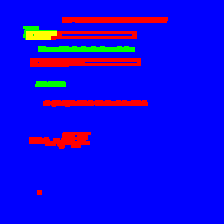

In [128]:
Image.fromarray((label.numpy().transpose((1, 2, 0))*255).astype(np.uint8))

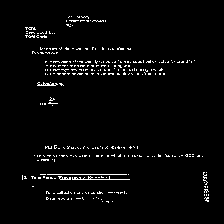

In [129]:
Image.fromarray((left.numpy().transpose((1, 2, 0))*255).astype(np.uint8))

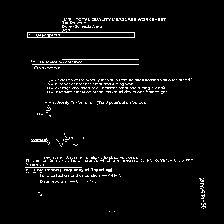

In [130]:
Image.fromarray((right.numpy().transpose((1, 2, 0))*255).astype(np.uint8))

## Training generator

In [131]:
data_loader = MyData()
left, right, lb0, lb1, lb2, lb3 = data_loader[56]

left = (left.numpy().squeeze()*255).astype(np.uint8)
right = (right.numpy().squeeze()*255).astype(np.uint8)
label = (lb0.numpy().squeeze()*255).astype(np.uint8)
label = label.transpose((1, 2, 0))
left = left.transpose((1, 2, 0))
right = right.transpose((1, 2, 0))

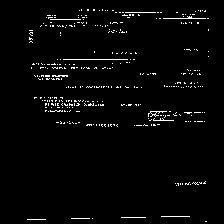

In [132]:
Image.fromarray(left)

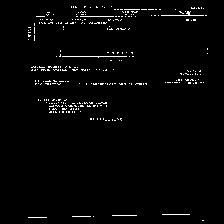

In [133]:
Image.fromarray(right)

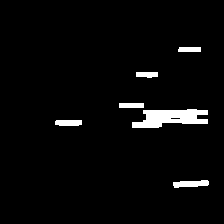

In [134]:
Image.fromarray(label[:,:,1])

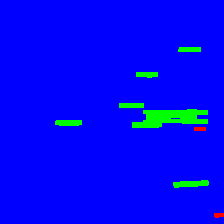

In [135]:
from PIL import Image
import numpy as np

Image.fromarray(label)

# Build Model

In [136]:
import numpy as np
import torch
from torch import nn
from torch.nn import init
import math

import math


def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=3, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def fuseforward(self, x):
        return self.act(self.conv(x))


class CrossConv(nn.Module):
    # Cross Convolution Downsample
    def __init__(self, c1, c2, k=3, s=1, g=1, e=1.0, shortcut=False):
        # ch_in, ch_out, kernel, stride, groups, expansion, shortcut
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_)  # , (1, k), (1, s))
        self.cv2 = Conv(c_, c2)  # , (k, 1), (s, 1), g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class ppattention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.conv = CrossConv(2 * in_planes, in_planes)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 输出最后两维1*1
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        # b,h,w,c   ---  n*c   #n,,c,h,w   ---- n*c
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                                nn.SiLU(),
                                nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()
        self.bnnorm = nn.BatchNorm2d(in_planes)

    def forward(self, x):
        x = self.conv(x)  # 2-->1,CROSS CONV
        res = x
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        attn = self.sigmoid(out)
        result = x * attn + res
        return result


class ppattention_wan(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.conv = CrossConv(2 * in_planes, in_planes)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 输出最后两维1*1
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        # b,h,w,c   ---  n*c   #n,,c,h,w   ---- n*c
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                                nn.SiLU(),
                                nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.fc2 = nn.Conv2d(1, 1, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.bnnorm = nn.BatchNorm2d(in_planes)

    def forward(self, x):
        x = self.conv(x)  # 2-->1,CROSS CONV
        res = x
        avg_out = self.fc(self.avg_pool(x))
        # max_out = self.fc(self.max_pool(x))
        # out = avg_out + max_out
        attn = self.sigmoid(avg_out)
        x_channel_summation = torch.sum(x, dim=1, keepdim=True)
        attn_channel_summation = self.sigmoid(self.fc2(x_channel_summation))
        result = x * attn + res + attn_channel_summation * res
        return result


class DFE(nn.Module):
    def __init__(self, in_planes):
        super().__init__()
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 2, 1, bias=False),
                                nn.BatchNorm2d(in_planes // 2),
                                nn.SiLU())

    def forward(self, x):
        result = self.fc(x)
        return result


class YTYAttention(nn.Module):

    def __init__(self, channel=512, reduction=16, im_channel=49):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.SiLU(),
            nn.Linear(channel // reduction, channel, bias=False),
        )
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(im_channel, 1, bias=False)
        self.fc2 = nn.Linear(im_channel, 1, bias=False)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, im1, im2):
        # b, c, _, _ = x.size()
        img = torch.cat([im1, im2], dim=2)
        origin = img
        im1 = im1.transpose(1, 2)
        im2 = im2.transpose(1, 2)
        im1 = self.fc1(im1)  # 1,512,1
        im2 = self.fc2(im2)  # 1,512,1

        im = torch.cat([im1, im2], dim=2)  # 1,512,2
        im = torch.transpose(im, 1, 2)  # 1,2,512
        im = self.fc(im)  # 1,2,512
        im1 = im[:, 0, :].unsqueeze(1)
        im2 = im[:, 1, :].unsqueeze(1)
        im = torch.cat([im1, im2], dim=2)
        im = im.transpose(1, 2)
        im = self.sigmoid(im)
        img = img.transpose(1, 2)
        res = img * im.expand_as(img)
        res = res.transpose(1, 2)
        return res


class TYAttention(nn.Module):
    def __init__(self, in_channel=1024, im_channel=49, gamma=2, b=1):
        super().__init__()
        self.fc1 = nn.Linear(im_channel, 1, bias=False)
        self.fc2 = nn.Linear(im_channel, 1, bias=False)
        self.SiLU = nn.SiLU()
        self.bn = nn.BatchNorm1d(2)
        self.gamma = gamma
        self.b = b
        self.sigmoid = nn.Sigmoid()
        self.in_channel = in_channel
        t = int(abs((math.log(self.in_channel, 2) + self.b) / self.gamma))
        k = t if t % 2 else t + 1
        self.conv = nn.Conv1d(2, 2, kernel_size=k, padding=int(k / 2), bias=False)
        self.conv2 = nn.Conv1d(2, 2, kernel_size=k, padding=int(k / 2), bias=False)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, im1, im2):
        img = torch.cat([im1, im1], dim=2)  # B,49,2048
        img = img.transpose(1, 2)
        origin = img
        im1 = im1.transpose(-1, -2)  # B,1024,49
        im2 = im2.transpose(-1, -2)

        im1 = self.fc1(im1)  # B,1024,1
        im2 = self.fc2(im2)
        im = torch.cat([im1, im2], dim=2)  # B,1024,2
        im = self.conv(im.transpose(-1, -2))  # B,2,1024
        im = self.SiLU(im)
        # im = self.bn(im)
        im = self.conv2(im)
        im1 = im[:, 0, :].unsqueeze(1)
        im2 = im[:, 1, :].unsqueeze(1)
        im = torch.cat([im1, im2], dim=2)  # B,1,2048
        im = im.transpose(1, 2)
        im = self.sigmoid(im)
        res = img * im.expand_as(img) + origin
        return res.transpose(1, 2)


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.conv = nn.Conv2d(3 * in_planes, in_planes, 1, 1, 0)
        self.bn = nn.BatchNorm2d(in_planes)
        self.SiLU = nn.SiLU()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 输出最后两维1*1
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                                nn.SiLU(),
                                nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()
        self.bnnorm = nn.BatchNorm2d(in_planes)

    def forward(self, x):
        x = self.conv(x)  # 2-1
        x = self.bn(x)
        x = self.SiLU(x)
        res = x
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        attn = self.sigmoid(out)
        out = x * attn + res
        return out


class ChannelAttention_1(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention_1, self).__init__()
        self.conv = nn.Conv2d(2 * in_planes, in_planes, 3, 1, 1)
        self.bn = nn.BatchNorm2d(in_planes)
        self.SiLU = nn.SiLU()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 输出最后两维1*1
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                                nn.SiLU(),
                                nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.SiLU(x)
        res = x
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        result = x * self.sigmoid(out) + res
        return result


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class CBAM(nn.Module):
    def __init__(self, in_planes):
        super(CBAM, self).__init__()
        self.channelattention = ChannelAttention_1(in_planes)
        self.spatialattention = SpatialAttention()

    def transpose(self, x):
        B, HW, C = x.size()
        H = int(math.sqrt(HW))
        x = x.transpose(1, 2)
        x = x.view(B, C, H, H)
        return x

    def transpose_verse(self, x):
        B, C, H, W = x.size()
        HW = H * W
        x = x.view(B, C, HW)
        x = x.transpose(1, 2)
        return x

    def forward(self, x1, x2):
        x1 = self.transpose(x1)
        x2 = self.transpose(x2)
        x = torch.cat([x1, x2], dim=1)

        channel_attn = self.channelattention(x)
        x1 = x1 * channel_attn
        x2 = x2 * channel_attn
        x1 = self.transpose_verse(x1)
        x2 = self.transpose_verse(x2)
        return x1, x2


class MixConv2d(nn.Module):
    # Mixed Depthwise Conv https://arxiv.org/abs/1907.09595
    def __init__(self, c1, c2, k=(1, 3, 5, 7), s=1, equal_ch=True):
        super().__init__()
        groups = len(k)
        if equal_ch:  # equal c_ per group
            i = torch.linspace(0, groups - 1E-6, c2).floor()  # c2 indices
            c_ = [(i == g).sum() for g in range(groups)]  # intermediate channels
        else:  # equal weight.numel() per group
            b = [c2] + [0] * groups
            a = np.eye(groups + 1, groups, k=-1)
            a -= np.roll(a, 1, axis=1)
            a *= np.array(k) ** 2
            a[0] = 1
            c_ = np.linalg.lstsq(a, b, rcond=None)[0].round()  # solve for equal weight indices, ax = b

        self.m = nn.ModuleList([nn.Conv2d(c1, int(c_[g]), k[g], s, k[g] // 2, bias=False) for g in range(groups)])
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(torch.cat([m(x) for m in self.m], 1)))

In [137]:
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import copy
# from YTYAttention import *


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)  # 如果换成384输入，这里无法被整除
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=256, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)  # 变成(224, 224)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]  # 整数除法
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim  # dim=96 Swin-T Swin-S的配置

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False) if dim_scale == 2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C // 4)
        x = x.view(B, -1, C // 4)
        x = self.norm(x)

        return x


class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm, patchsize=4):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, patchsize * patchsize * dim, bias=False)
        self.output_dim = dim
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale,
                      c=C // (self.dim_scale ** 2))
        x = x.view(B, -1, self.output_dim)
        x = self.norm(x)

        return x


class FinalPatchExpand_X4_1(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=1, norm_layer=nn.LayerNorm, patchsize=1):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        # self.expand = nn.Linear(dim, patchsize*patchsize*dim, bias=False)
        self.output_dim = dim
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        # x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale,
                      c=C // (self.dim_scale ** 2))
        x = x.view(B, -1, self.output_dim)
        x = self.norm(x)

        return x


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,  # 相邻两个trans blocks, 一个shift，一个不用
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class BasicLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x


class SwinTransEncoder(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=2,
                 embed_dim=192, depths=[2, 2, 18, 2], depths_decoder=[4, 4, 4, 4], num_heads=[6, 12, 24, 48],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()

        print(
            "SwinTransformerSys expand initial----depths:{};depths_decoder:{};drop_path_rate:{};num_classes:{}".format(
                depths,
                depths_decoder, drop_path_rate, num_classes))

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        self.deal = nn.ModuleList()
        self.deal.append(nn.LayerNorm(128))
        self.deal.append(nn.LayerNorm(256))
        self.deal.append(nn.LayerNorm(512))
        self.deal.append(nn.LayerNorm(1024))

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build encoder and bottleneck layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.fusion = ChannelAttention_1(1024)

    # Encoder and Bottleneck
    def transpose(self, x):
        B, HW, C = x.size()
        H = int(math.sqrt(HW))
        x = x.transpose(1, 2)
        x = x.view(B, C, H, H)
        return x

    def transpose_verse(self, x):
        B, C, H, W = x.size()
        x = x.view(B, C, -1)
        x = x.transpose(1, 2)
        return x

    def forward(self, x1, x2):
        # input [1,3,224,224]
        x1 = self.patch_embed(x1)  # [1,56x56,96(embedding dim)]
        x2 = self.patch_embed(x2)  # [1,56x56,96(embedding dim)]
        if self.ape:
            x1 = x1 + self.absolute_pos_embed
            x2 = x2 + self.absolute_pos_embed
        x1 = self.pos_drop(x1)
        x2 = self.pos_drop(x2)
        x1_downsample = []
        x2_downsample = []

        for inx, layer in enumerate(self.layers):
            if inx != 3:
                x1_downsample.append(self.deal[inx](x1))  # self.deal[inx](x))  #self.deal[inx]
                x2_downsample.append(self.deal[inx](x2))
                x1 = layer(x1)  # ??norm(  mlp(layer_norm(self-attention(x)))
                x2 = layer(x2)
            else:
                x1_downsample.append(self.deal[inx](x1))  # self.deal[inx](x))  #self.deal[inx]
                x2_downsample.append(self.deal[inx](x2))
                x_mid = self.transpose_verse(self.fusion(self.transpose(torch.cat([x1, x2], dim=2))))
                x_mid = layer(x_mid)
        # x_mid = torch.cat([x1,x2],dim=2)
        # x1 = self.norm(x1)
        # x2 = self.norm(x2)
        # x_mid = self.transpose_verse(self.fusion(self.transpose(torch.cat([x1,x2],dim=2))))
        x_mid = self.norm(x_mid)  # B L C --1 49 768]

        return x_mid, x1_downsample, x2_downsample


# TODO finish this part to transfer trans 2 cnn
class PatchUnembed(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, final_dim=64, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale

        self.final_dim = final_dim

        self.expand = nn.Linear(dim, 16 * final_dim, bias=False)
        self.output_dim = dim // self.dim_scale ** 2

        self.norm = norm_layer(self.final_dim)

        # self.output = nn.Conv2d(in_channels=self.output_dim,out_channels=self.final_dim,kernel_size=1,bias=False)

    def forward(self, x):
        """
        x: B, H*W, C
        -> B, C/16, H*4, W*4
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = self.expand(x)
        C = 16 * self.final_dim
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale,
                      c=C // (self.dim_scale ** 2))
        x = x.view(B, -1, self.final_dim)
        x = self.norm(x)

        x = x.view(B, 4 * H, 4 * W, -1)
        x = x.permute(0, 3, 1, 2)  # B,C,H,W
        # x = self.output(x)

        return x


class SwinTransDecoder(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=2,
                 embed_dim=128, depths=[4, 4, 4, 4], depths_decoder=[2, 2, 2, 2], num_heads=[4, 8, 16, 32],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample
        self.patches_resolution = [img_size // patch_size, img_size // patch_size]
        self.patch_size = patch_size

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.concat_linear0 = nn.Linear(1024, 1024)

        self.norm = nn.ModuleList()
        self.norm.append(nn.LayerNorm(512))
        self.norm.append(nn.LayerNorm(256))
        self.norm.append(nn.LayerNorm(128))
        self.norm.append(nn.LayerNorm(128))

        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                      int(embed_dim * 2 ** (
                                                  self.num_layers - 1 - i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer == 0:
                layer_up = PatchExpand(
                    input_resolution=(self.patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                      self.patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                    dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                         input_resolution=(
                                         self.patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                         self.patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                                         depth=depths[(self.num_layers - 1 - i_layer)],
                                         num_heads=num_heads[(self.num_layers - 1 - i_layer)],
                                         window_size=window_size,
                                         mlp_ratio=self.mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop_rate, attn_drop=attn_drop_rate,
                                         drop_path=dpr[sum(depths[:(self.num_layers - 1 - i_layer)]):sum(
                                             depths[:(self.num_layers - 1 - i_layer) + 1])],
                                         norm_layer=norm_layer,
                                         upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                         use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm_up = norm_layer(self.embed_dim)
        if self.final_upsample == "expand_first":
            # print("---final upsample expand_first---")
            self.up = FinalPatchExpand_X4(input_resolution=(img_size // patch_size, img_size // patch_size),
                                          dim_scale=4, dim=embed_dim, patchsize=patch_size)
            self.up_0 = FinalPatchExpand_X4_1(input_resolution=(56, 56), dim_scale=1, dim=128, patchsize=1)
            self.up_1 = FinalPatchExpand_X4_1(input_resolution=(28, 28), dim_scale=1, dim=256, patchsize=1)
            self.up_2 = FinalPatchExpand_X4_1(input_resolution=(14, 14), dim_scale=1, dim=512, patchsize=1)
            self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)
            self.output_0 = nn.Conv2d(in_channels=128, out_channels=self.num_classes, kernel_size=1, bias=False)
            self.output_1 = nn.Conv2d(in_channels=256, out_channels=self.num_classes, kernel_size=1, bias=False)
            self.output_2 = nn.Conv2d(in_channels=512, out_channels=self.num_classes, kernel_size=1, bias=False)

        self.ppattention = nn.ModuleList()
        self.ppattention.append(ppattention_wan(1024))
        self.ppattention.append(ppattention_wan(512))
        self.ppattention.append(ppattention_wan(256))
        self.ppattention.append(ppattention_wan(128))

        self.DFE = nn.ModuleList()
        self.DFE.append(DFE(1024))
        self.DFE.append(DFE(512))
        self.DFE.append(DFE(256))
        self.DFE.append(DFE(128))

        self.norm_bn = nn.ModuleList()
        self.norm_bn.append(nn.BatchNorm2d(2048))
        self.norm_bn.append(nn.BatchNorm2d(1024))
        self.norm_bn.append(nn.BatchNorm2d(512))
        self.norm_bn.append(nn.BatchNorm2d(256))

        self.channelattention = ChannelAttention(1024)
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)

    def transpose(self, x):
        B, HW, C = x.size()
        H = int(math.sqrt(HW))
        x = x.transpose(1, 2)
        x = x.view(B, C, H, H)
        return x

    def transpose_verse(self, x):
        B, C, H, W = x.size()
        x = x.view(B, C, -1)
        x = x.transpose(1, 2)
        return x

    def forward_up_features(self, x_mid, x_downsample1, x_downsample2):  # 1/4,1/8,1/16,1/32,     1/32
        x_upsample = []
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                t1 = self.transpose(x_downsample1[3])  # B,C,H,W    mlp
                t2 = self.transpose(x_downsample2[3])
                diff_feature = t1 - t2  # 1024
                add_feature = t1 + t2

                x_mid = self.transpose(x_mid)
                x_mid = torch.cat([x_mid, x_mid], dim=1)
                # hidden = torch.cat([x_mid,t1,t2],dim=1)
                hidden = torch.cat([diff_feature, add_feature], dim=1)
                hidden = x_mid + hidden
                # hidden = self.norm_bn[inx](hidden)
                x = self.transpose_verse(self.ppattention[inx](hidden))  # B,HW,C

                x = self.concat_linear0(x)  # C,C  1024
                y1 = layer_up(x)  # C/2  UP SAMPLE  512
                y2 = y1  # B,HW,C/2     512
                x = torch.cat([y1, y2], dim=2)  # C    B,HW,C     1024
                x_upsample.append(self.norm[0](y1))  # B,HW,C/2
            else:
                t1 = self.transpose(x_downsample1[3 - inx])  # 512
                t2 = self.transpose(x_downsample2[3 - inx])
                diff_feature = t1 - t2
                add_feature = t1 + t2

                x = self.transpose(x)  # 1024
                # hidden = torch.cat([x,t1,t2],dim=1)
                hidden = torch.cat([diff_feature, add_feature], dim=1)
                hidden = x + hidden
                # hidden = self.norm_bn[inx](hidden)
                x = self.ppattention[inx](hidden)
                x = self.transpose_verse(x)  # B,HW,C
                x = self.concat_back_dim[inx](x)  ######

                y1 = layer_up(x)  # layer up 初始层有norm,up  norm,norm,up
                y2 = y1
                x = torch.cat([y1, y2], dim=2)  # C1024
                norm = self.norm[inx]
                x_upsample.append((norm(y1)))

        x = self.norm_up(y1)  # B L C   最终预测结果

        return x, x_upsample

    def up_x4(self, x, pz):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "input features has wrong size"

        if self.final_upsample == "expand_first":
            x = self.up(x)
            x = x.view(B, pz * H, pz * W, -1)
            x = x.permute(0, 3, 1, 2)  # B,C,H,W
            x = self.output(x)

        return x

    def up_x4_1(self, x, pz):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "input features has wrong size"

        if self.final_upsample == "expand_first":
            x = self.up_0(x)
            x = x.view(B, pz * H, pz * W, -1)
            x = x.permute(0, 3, 1, 2)  # B,C,H,W
            x = self.output_0(x)

        return x

    def up_x8(self, x, pz):
        H, W = (28, 28)
        B, L, C = x.shape
        assert L == H * W, "input features has wrong size"

        if self.final_upsample == "expand_first":
            # x = self.up(x,patchsize=pz)
            x = self.up_1(x)
            x = x.view(B, pz * H, pz * W, -1)
            x = x.permute(0, 3, 1, 2)  # B,C,H,W
            x = self.output_1(x)

        return x

    def up_x16(self, x, pz):
        H, W = (14, 14)
        B, L, C = x.shape
        assert L == H * W, "input features has wrong size"

        if self.final_upsample == "expand_first":
            # x = self.up(x,patchsize=pz)
            x = self.up_2(x)
            x = x.view(B, pz * H, pz * W, -1)
            x = x.permute(0, 3, 1, 2)  # B,C,H,W
            x = self.output_2(x)

        return x

    def forward(self, x, x_down1, x_down2):
        x, x_upsample = self.forward_up_features(x, x_down1, x_down2)

        x_p = self.up_x4(x, self.patch_size)
        x_pre2 = self.up_x4_1(x_upsample[2], 1)
        x_pre3 = self.up_x8(x_upsample[1], 1)
        x_pre4 = self.up_x16(x_upsample[0], 1)

        return x_p, x_pre2, x_pre3, x_pre4


class encoder1(nn.Module):
    def __init__(self, img_size = 224, in_chans=3):
        super(encoder1, self).__init__()
        self.encoder1 = SwinTransEncoder(img_size=img_size, patch_size=4, in_chans=in_chans, num_classes=2, embed_dim=128,
                                         depths=[2, 2, 18, 2], depths_decoder=[4, 4, 4, 4], num_heads=[4, 8, 16, 32],
                                         window_size=7)
        self.pretrained_path = 'swin_pretrain_224.pth'
        self.load_from()

    def load_from(self):
        pretrained_path = self.pretrained_path
        if pretrained_path is not None:
            print("pretrained_path:{}".format(pretrained_path))
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            pretrained_dict = torch.load(pretrained_path, map_location=device)
            if "model" not in pretrained_dict:
                print("---start load pretrained modle by splitting---")
                pretrained_dict = {k[17:]: v for k, v in pretrained_dict.items()}
                for k in list(pretrained_dict.keys()):
                    if "output" in k:
                        print("delete key:{}".format(k))
                        del pretrained_dict[k]
                msg = self.encoder1.load_state_dict(pretrained_dict, strict=False)
                return
            pretrained_dict = pretrained_dict['model']
            print("---start load pretrained modle of swin encoder---")

            model_dict = self.encoder1.state_dict()
            full_dict = copy.deepcopy(pretrained_dict)
            for k, v in pretrained_dict.items():
                if "layers." in k:
                    current_layer_num = 3 - int(k[7:8])
                    current_k = "layers_up." + str(current_layer_num) + k[8:]
                    full_dict.update({current_k: v})
            for k in list(full_dict.keys()):
                if k in model_dict:
                    # print(1)
                    if full_dict[k].shape != model_dict[k].shape:
                        print("delete:{};shape pretrain:{};shape model:{}".format(k, v.shape, model_dict[k].shape))
                        del full_dict[k]

            msg = self.encoder1.load_state_dict(full_dict, strict=False)
        else:
            print("none pretrain")

    def forward(self, img1, img2):
        x, y1, y2 = self.encoder1(img1, img2)
        return x, y1, y2


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder1 = encoder1(img_size=224, in_chans=3)
        self.decoder = SwinTransDecoder(num_classes=3)

    def forward(self, img1, img2):
        x, x_downsample1, x_downsample2 = self.encoder1(img1, img2)
        x_p, x_2, x_3, x_4 = self.decoder(x, x_downsample1, x_downsample2)

        return x_p, x_2, x_3, x_4

# Train

In [138]:
import math


class LR_Scheduler(object):
    """Learning Rate Scheduler

    Step mode: ``lr = baselr * 0.1 ^ {floor(epoch-1 / lr_step)}``

    Cosine mode: ``lr = baselr * 0.5 * (1 + cos(iter/maxiter))``

    Poly mode: ``lr = baselr * (1 - iter/maxiter) ^ 0.9``

    Args:
        args:  :attr:`args.lr_scheduler` lr scheduler mode (`cos`, `poly`),
          :attr:`args.lr` base learning rate, :attr:`args.epochs` number of epochs,
          :attr:`args.lr_step`

        iters_per_epoch: number of iterations per epoch
    """

    def __init__(self, mode, base_lr, num_epochs, iters_per_epoch=0,
                 lr_step=0, warmup_epochs=0):
        self.mode = mode
        print('Using {} LR Scheduler!'.format(self.mode))
        self.lr = base_lr
        if mode == 'step':
            assert lr_step
        self.lr_step = lr_step
        self.iters_per_epoch = iters_per_epoch
        self.N = num_epochs * iters_per_epoch
        self.epoch = -1
        self.warmup_iters = warmup_epochs * iters_per_epoch

    def __call__(self, optimizer, i, epoch, best_pred=0.0):
        T = epoch * self.iters_per_epoch + i
        if self.mode == 'cos':
            lr = 0.5 * self.lr * (1 + math.cos(1.0 * (T - self.warmup_iters) / (self.N - self.warmup_iters) * math.pi))
        elif self.mode == 'poly':
            lr = self.lr * pow((1 - 1.0 * T / self.N), 0.9)
        elif self.mode == 'step':
            lr = self.lr * (0.1 ** (epoch // self.lr_step))
        elif self.mode == 'linear':
            if T < self.warmup_iters:
                lr = self.lr
            else:
                lr = self.lr * 1.0 * (2 - T / self.warmup_iters)
        else:
            raise NotImplemented

        if self.warmup_iters > 0 and T < self.warmup_iters:
            lr = lr * 1.0 * T / self.warmup_iters
        if epoch > self.epoch:
            self.epoch = epoch
        assert lr >= 0
        self._adjust_learning_rate(optimizer, lr)

    def _adjust_learning_rate(self, optimizer, lr):
        if len(optimizer.param_groups) == 1:
            optimizer.param_groups[0]['lr'] = lr
        else:
            optimizer.param_groups[0]['lr'] = lr * 0.1
            for i in range(1, len(optimizer.param_groups)):
                optimizer.param_groups[i]['lr'] = lr

In [139]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

# def _iou(pred, target, size_average = True):
#     #print(pred.shape,target.shape)
#     pred = pred[:,1,:,:]
#     #print(pred.shape,'\n','------------------------','\n',target.shape)
#     b = pred.shape[0]
#     IoU = 0.0
#     for i in range(0,b):
#         #compute the IoU of the foreground
#         Iand1 = torch.sum(target[i,:,:]*pred[i,:,:])
#         Ior1 = torch.sum(target[i,:,:]) + torch.sum(pred[i,:,:])-Iand1
#         IoU1 = Iand1/Ior1

#         #IoU loss is (1-IoU1)
#         IoU = IoU + (1-IoU1)

#     return IoU/b

# class IOU(torch.nn.Module):
#     def __init__(self, size_average = True):
#         super(IOU, self).__init__()
#         self.size_average = size_average

#     def forward(self, pred, target):

#         return _iou(pred, target, self.size_average)

def _iou(pred, target, size_average = True):
    b = pred.shape[0]
    c = pred.shape[1] # Number of classes
    IoU = 0.0
    for i in range(0,b):
        IoU_class = 0.0
        for j in range(0,c):
            #compute the IoU of the each class
            Iand1 = torch.sum(target[i,j,:,:]*pred[i,j,:,:])
            Ior1 = torch.sum(target[i,j,:,:]) + torch.sum(pred[i,j,:,:])-Iand1
            IoU1 = Iand1/Ior1 if Ior1 != 0 else 0  # Ensure division by zero doesn't occur

            # IoU loss is (1-IoU1) for each class
            IoU_class += (1-IoU1)
        
        # Average over classes
        IoU += IoU_class/c

    return IoU/b


class IOU(torch.nn.Module):
    def __init__(self, size_average = True):
        super(IOU, self).__init__()
        self.size_average = size_average

    def forward(self, pred, target):
        return _iou(pred, target, self.size_average)



# https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2): # Here berg
        # img1 = img1[:,1,:,:].unsqueeze(1)
        # img2 = img2.unsqueeze(1)
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def _logssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    ssim_map = (ssim_map - torch.min(ssim_map))/(torch.max(ssim_map)-torch.min(ssim_map))
    ssim_map = -torch.log(ssim_map + 1e-8)

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class LOGSSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(LOGSSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel


        return _logssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    print(f'There are {channel} channels in img1')
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

In [140]:
assert False

AssertionError: 

In [141]:
model = Encoder().cuda()
model.load_state_dict(torch.load('docdiffV2.pth'))

SwinTransformerSys expand initial----depths:[2, 2, 18, 2];depths_decoder:[4, 4, 4, 4];drop_path_rate:0.1;num_classes:2
pretrained_path:swin_pretrain_224.pth
---start load pretrained modle of swin encoder---


<All keys matched successfully>

In [ ]:
import pickle
model = pickle.load(open('DocDiff(varying_translations).pkl', 'rb'))

In [35]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

168529324

In [143]:
import torch
import torch.nn as nn
import tqdm
# from my_scheduler import LR_Scheduler
# from swin_ynet import Encoder
# from data.dataset_swin_sysu import MyData
import torch.optim as optim
from torch.utils.data import DataLoader
import warnings

# warnings.filterwarnings("ignore")


# import pytorch_iou
# import pytorch_ssim

deal = nn.Softmax(dim=1)


def all_loss(pred, gt):
    ce_loss = nn.CrossEntropyLoss()
    ssim_loss = SSIM(window_size=11, size_average=True).cuda()
    iou_loss = IOU().cuda()
    ce_out = ce_loss(pred, gt.long())
    ssim_out = 1 - ssim_loss(deal(pred), gt)
    iou_out = iou_loss(deal(pred), gt)
    loss = ce_out + ssim_out + iou_out
    return loss


model = model.train()
ce_loss = nn.CrossEntropyLoss()
ssim_loss = SSIM(window_size=7, size_average=True).cuda()
iou_loss = IOU().cuda()
LR = 0.01
LR_VGG = 0.00001
EPOCH = 80
scheduler = LR_Scheduler('cos', LR, EPOCH, 16000 // 10)

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005, nesterov=False)


def make_optimizer(LR, model):
    params = []
    for key, value in model.named_parameters():
        # print(key)
        if not value.requires_grad:
            continue
        if "encoder1" in key:
            lr = LR * 0.1
        else:
            lr = LR
        params += [{"params": [value], "lr": lr}]
    optimizer = getattr(torch.optim, "SGD")(params, momentum=0.9, weight_decay=0.0005, nesterov=False)
    return optimizer


train_loader = DataLoader(MyData(),
                          shuffle=True,
                          batch_size=1,
                          pin_memory=True,
                        #   num_workers=1,
                          )

losses0 = 0
losses1 = 0
losses2 = 0
losses3 = 0
losses4 = 0
losses5 = 0
losses6 = 0
losses7 = 0
losses8 = 0
losses9 = 0
losses10 = 0
losses11 = 0

print('Train Loader Length: ', len(train_loader))


def adjust_learning_rate(optimizer, epoch, start_lr):
    if epoch % 20 == 0:  # epoch != 0 and
        for param_group in optimizer.param_groups:
            param_group["lr"] = param_group["lr"] * 0.1
        print(param_group["lr"])


loss_least = 100000
for epoch_num in range(EPOCH):
    print(epoch_num)
    adjust_learning_rate(optimizer, epoch_num, LR)
    print('LR is:', optimizer.state_dict()['param_groups'][0]['lr'])
    show_dict = {'epoch': epoch_num}

    loss_all = 0
    for i_batch, (im1, im2, label0, label1, label2, label3) in enumerate(
            tqdm.tqdm(train_loader, ncols=60, postfix=show_dict)):  # ,edge0,edge1,edge2,edge3
        im1 = im1.cuda()
        im2 = im2.cuda()
        label0 = label0.cuda()
        label1 = label1.cuda()
        label2 = label2.cuda()
        label3 = label3.cuda()

        outputs = model(im1, im2)

        # assert False
        loss0 = ce_loss(outputs[0], label0.float())
        loss1 = ce_loss(outputs[1], label1.float())
        loss2 = ce_loss(outputs[2], label2.float())
        loss3 = ce_loss(outputs[3], label3.float())

        loss4 = 1. - ssim_loss(deal(outputs[0]), label0)
        loss5 = 1. - ssim_loss(deal(outputs[1]), label1)
        loss6 = 1. - ssim_loss(deal(outputs[2]), label2)
        loss7 = 1. - ssim_loss(deal(outputs[3]), label3)

        loss8 = iou_loss(deal(outputs[0]), label0)
        loss9 = iou_loss(deal(outputs[1]), label1)
        loss10 = iou_loss(deal(outputs[2]), label2)
        loss11 = iou_loss(deal(outputs[3]), label3)

        loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7 + loss8 + loss9 + loss10 + loss11
        loss_all += loss

        losses0 += loss0
        losses1 += loss1
        losses2 += loss2
        losses3 += loss3
        losses4 += loss4
        losses5 += loss5
        losses6 += loss6
        losses7 += loss7
        losses8 += loss8
        losses9 += loss9
        losses10 += loss10
        losses11 += loss11

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_batch % 100 == 0:
            print(i_batch, '|', 'losses0: {:.3f}'.format(losses0.data), '|', 'losses1: {:.3f}'.format(losses1.data),
                  '|', 'losses2: {:.3f}'.format(losses2.data), '|', 'losses3: {:.3f}'.format(losses3.data), '|',
                  'losses4: {:.3f}'.format(losses4.data), '|', 'losses5: {:.3f}'.format(losses5.data), '|',
                  'losses6: {:.3f}'.format(losses6.data), '|', 'losses7: {:.3f}'.format(losses7.data),
                  'losses8: {:.3f}'.format(losses8.data), '|', 'losses9: {:.3f}'.format(losses9.data), '|',
                  'losses10: {:.3f}'.format(losses10.data), '|', 'losses11: {:.3f}'.format(losses11.data))

            losses0 = 0
            losses1 = 0
            losses2 = 0
            losses3 = 0
            losses4 = 0
            losses5 = 0
            losses6 = 0
            losses7 = 0
            losses8 = 0
            losses9 = 0
            losses10 = 0
            losses11 = 0

    if loss_all <= loss_least:
        loss_least = loss_all
        torch.save(model.state_dict(), 'docdiffV2_rvl.pth')
        print('\n', 'epoch:', epoch_num, 'epoch loss:', loss_all)

Using cos LR Scheduler!
Train Loader Length:  1360
0
0.001
LR is: 0.001


  0%|             | 1/1360 [00:00<14:28,  1.56it/s, epoch=0]

0 | losses0: 0.220 | losses1: 0.194 | losses2: 0.172 | losses3: 0.052 | losses4: 0.096 | losses5: 0.234 | losses6: 0.360 | losses7: 0.252 losses8: 0.682 | losses9: 0.679 | losses10: 0.680 | losses11: 0.673


  7%|▊          | 101/1360 [00:55<10:40,  1.96it/s, epoch=0]

100 | losses0: 16.123 | losses1: 16.235 | losses2: 17.974 | losses3: 23.201 | losses4: 8.163 | losses5: 15.383 | losses6: 21.913 | losses7: 29.811 losses8: 48.205 | losses9: 48.928 | losses10: 52.249 | losses11: 59.207


 15%|█▋         | 201/1360 [01:57<09:25,  2.05it/s, epoch=0]

200 | losses0: 14.968 | losses1: 15.105 | losses2: 16.389 | losses3: 21.044 | losses4: 7.403 | losses5: 14.470 | losses6: 20.430 | losses7: 28.279 losses8: 46.799 | losses9: 47.128 | losses10: 51.147 | losses11: 57.723


 22%|██▍        | 301/1360 [02:56<09:33,  1.85it/s, epoch=0]

300 | losses0: 15.283 | losses1: 15.739 | losses2: 16.258 | losses3: 18.936 | losses4: 8.025 | losses5: 16.006 | losses6: 21.930 | losses7: 29.931 losses8: 47.171 | losses9: 48.145 | losses10: 50.790 | losses11: 58.811


 29%|███▏       | 401/1360 [03:59<12:42,  1.26it/s, epoch=0]

400 | losses0: 16.226 | losses1: 15.983 | losses2: 16.534 | losses3: 21.593 | losses4: 8.119 | losses5: 15.425 | losses6: 21.428 | losses7: 29.125 losses8: 46.661 | losses9: 47.334 | losses10: 50.346 | losses11: 56.425


 37%|████       | 501/1360 [04:59<09:11,  1.56it/s, epoch=0]

500 | losses0: 13.304 | losses1: 13.070 | losses2: 15.015 | losses3: 15.421 | losses4: 6.962 | losses5: 13.584 | losses6: 20.290 | losses7: 24.013 losses8: 46.719 | losses9: 47.047 | losses10: 50.488 | losses11: 56.898


 44%|████▊      | 601/1360 [05:57<08:14,  1.54it/s, epoch=0]

600 | losses0: 14.550 | losses1: 14.834 | losses2: 15.542 | losses3: 18.469 | losses4: 7.132 | losses5: 14.392 | losses6: 19.887 | losses7: 26.763 losses8: 47.561 | losses9: 47.959 | losses10: 50.072 | losses11: 57.608


 52%|█████▋     | 701/1360 [06:54<07:21,  1.49it/s, epoch=0]

700 | losses0: 15.787 | losses1: 16.064 | losses2: 17.976 | losses3: 20.014 | losses4: 8.479 | losses5: 15.356 | losses6: 21.820 | losses7: 28.042 losses8: 46.170 | losses9: 46.820 | losses10: 50.333 | losses11: 56.635


 59%|██████▍    | 801/1360 [07:53<06:05,  1.53it/s, epoch=0]

800 | losses0: 15.972 | losses1: 15.956 | losses2: 17.131 | losses3: 16.546 | losses4: 8.156 | losses5: 15.396 | losses6: 21.231 | losses7: 25.933 losses8: 48.372 | losses9: 48.833 | losses10: 50.918 | losses11: 55.534


 66%|███████▎   | 901/1360 [08:51<05:13,  1.47it/s, epoch=0]

900 | losses0: 15.631 | losses1: 15.789 | losses2: 15.586 | losses3: 19.651 | losses4: 7.966 | losses5: 15.460 | losses6: 21.378 | losses7: 28.371 losses8: 47.065 | losses9: 47.679 | losses10: 50.669 | losses11: 57.848


 74%|███████▎  | 1001/1360 [09:51<04:22,  1.37it/s, epoch=0]

1000 | losses0: 15.708 | losses1: 16.066 | losses2: 16.141 | losses3: 20.742 | losses4: 7.727 | losses5: 15.256 | losses6: 21.066 | losses7: 29.261 losses8: 44.892 | losses9: 45.631 | losses10: 48.104 | losses11: 56.749


 81%|████████  | 1101/1360 [10:52<02:53,  1.49it/s, epoch=0]

1100 | losses0: 13.312 | losses1: 13.130 | losses2: 13.889 | losses3: 14.812 | losses4: 6.847 | losses5: 13.797 | losses6: 20.409 | losses7: 24.864 losses8: 47.597 | losses9: 48.339 | losses10: 50.553 | losses11: 58.319


 88%|████████▊ | 1201/1360 [11:55<02:01,  1.31it/s, epoch=0]

1200 | losses0: 16.026 | losses1: 15.586 | losses2: 16.246 | losses3: 19.881 | losses4: 8.417 | losses5: 15.630 | losses6: 21.176 | losses7: 26.961 losses8: 46.595 | losses9: 46.766 | losses10: 49.025 | losses11: 55.371


 96%|█████████▌| 1301/1360 [12:59<00:40,  1.44it/s, epoch=0]

1300 | losses0: 15.503 | losses1: 15.405 | losses2: 15.906 | losses3: 16.319 | losses4: 8.095 | losses5: 15.873 | losses6: 22.571 | losses7: 25.743 losses8: 48.185 | losses9: 48.679 | losses10: 50.731 | losses11: 55.879


100%|██████████| 1360/1360 [13:36<00:00,  1.67it/s, epoch=0]



 epoch: 0 epoch loss: tensor(4597.5527, device='cuda:0', grad_fn=<AddBackward0>)
1
LR is: 0.001


  0%|             | 1/1360 [00:00<20:13,  1.12it/s, epoch=1]

0 | losses0: 7.268 | losses1: 7.480 | losses2: 8.535 | losses3: 7.650 | losses4: 4.253 | losses5: 8.161 | losses6: 11.978 | losses7: 12.508 losses8: 26.550 | losses9: 26.997 | losses10: 29.469 | losses11: 31.881


  7%|▊          | 101/1360 [01:02<13:28,  1.56it/s, epoch=1]

100 | losses0: 13.945 | losses1: 13.955 | losses2: 15.465 | losses3: 13.262 | losses4: 7.273 | losses5: 13.725 | losses6: 19.620 | losses7: 22.283 losses8: 40.840 | losses9: 41.133 | losses10: 44.626 | losses11: 49.356


 15%|█▋         | 201/1360 [02:13<33:07,  1.72s/it, epoch=1]

200 | losses0: 12.621 | losses1: 12.568 | losses2: 12.410 | losses3: 15.010 | losses4: 5.971 | losses5: 12.260 | losses6: 17.653 | losses7: 22.009 losses8: 47.065 | losses9: 47.249 | losses10: 49.092 | losses11: 55.259


 22%|██▍        | 301/1360 [03:38<11:10,  1.58it/s, epoch=1]

300 | losses0: 14.081 | losses1: 13.862 | losses2: 15.625 | losses3: 14.843 | losses4: 7.002 | losses5: 13.269 | losses6: 18.949 | losses7: 22.147 losses8: 45.614 | losses9: 45.854 | losses10: 48.351 | losses11: 53.427


 29%|███▏       | 401/1360 [04:39<09:25,  1.70it/s, epoch=1]

400 | losses0: 15.213 | losses1: 15.127 | losses2: 15.449 | losses3: 17.561 | losses4: 7.887 | losses5: 14.423 | losses6: 19.475 | losses7: 24.014 losses8: 42.575 | losses9: 42.713 | losses10: 45.445 | losses11: 49.718


 37%|████       | 501/1360 [05:47<07:32,  1.90it/s, epoch=1]

500 | losses0: 14.050 | losses1: 13.930 | losses2: 15.065 | losses3: 17.109 | losses4: 7.041 | losses5: 13.372 | losses6: 18.793 | losses7: 21.827 losses8: 43.475 | losses9: 43.987 | losses10: 47.386 | losses11: 50.217


 44%|████▊      | 601/1360 [06:51<06:57,  1.82it/s, epoch=1]

600 | losses0: 13.672 | losses1: 13.526 | losses2: 15.010 | losses3: 16.266 | losses4: 7.099 | losses5: 13.794 | losses6: 19.134 | losses7: 22.939 losses8: 43.740 | losses9: 44.242 | losses10: 47.289 | losses11: 51.975


 52%|█████▋     | 701/1360 [08:04<07:27,  1.47it/s, epoch=1]

700 | losses0: 13.232 | losses1: 13.284 | losses2: 13.539 | losses3: 16.342 | losses4: 6.896 | losses5: 13.404 | losses6: 17.602 | losses7: 23.515 losses8: 43.592 | losses9: 43.844 | losses10: 44.596 | losses11: 53.068


 59%|██████▍    | 801/1360 [09:07<05:27,  1.71it/s, epoch=1]

800 | losses0: 15.747 | losses1: 15.535 | losses2: 16.556 | losses3: 16.337 | losses4: 7.787 | losses5: 15.056 | losses6: 20.945 | losses7: 25.133 losses8: 44.584 | losses9: 45.411 | losses10: 47.615 | losses11: 51.688


 66%|███████▎   | 901/1360 [10:06<05:07,  1.49it/s, epoch=1]

900 | losses0: 13.063 | losses1: 13.316 | losses2: 13.809 | losses3: 13.597 | losses4: 6.778 | losses5: 13.644 | losses6: 19.255 | losses7: 22.709 losses8: 43.012 | losses9: 43.179 | losses10: 45.543 | losses11: 51.417


 74%|███████▎  | 1001/1360 [11:07<03:53,  1.54it/s, epoch=1]

1000 | losses0: 14.136 | losses1: 13.925 | losses2: 14.365 | losses3: 16.963 | losses4: 7.140 | losses5: 13.581 | losses6: 18.740 | losses7: 21.830 losses8: 45.854 | losses9: 46.175 | losses10: 47.823 | losses11: 51.796


 81%|████████  | 1101/1360 [12:13<03:02,  1.42it/s, epoch=1]

1100 | losses0: 15.102 | losses1: 14.894 | losses2: 15.144 | losses3: 17.295 | losses4: 7.508 | losses5: 13.820 | losses6: 18.409 | losses7: 24.761 losses8: 44.960 | losses9: 45.192 | losses10: 46.117 | losses11: 53.583


 88%|████████▊ | 1201/1360 [13:15<01:54,  1.38it/s, epoch=1]

1200 | losses0: 13.593 | losses1: 13.786 | losses2: 14.463 | losses3: 15.967 | losses4: 6.994 | losses5: 13.303 | losses6: 18.299 | losses7: 22.960 losses8: 44.407 | losses9: 45.106 | losses10: 46.408 | losses11: 52.770


 96%|█████████▌| 1301/1360 [14:20<00:37,  1.55it/s, epoch=1]

1300 | losses0: 14.651 | losses1: 14.927 | losses2: 14.711 | losses3: 16.746 | losses4: 6.965 | losses5: 13.921 | losses6: 19.121 | losses7: 23.162 losses8: 44.535 | losses9: 44.752 | losses10: 47.879 | losses11: 52.656


100%|██████████| 1360/1360 [14:56<00:00,  1.52it/s, epoch=1]



 epoch: 1 epoch loss: tensor(4211.9341, device='cuda:0', grad_fn=<AddBackward0>)
2
LR is: 0.001


  0%|             | 1/1360 [00:00<16:45,  1.35it/s, epoch=2]

0 | losses0: 7.904 | losses1: 7.966 | losses2: 8.088 | losses3: 8.673 | losses4: 3.876 | losses5: 8.139 | losses6: 11.812 | losses7: 12.579 losses8: 30.044 | losses9: 30.220 | losses10: 30.886 | losses11: 32.864


  7%|▊          | 101/1360 [00:39<09:37,  2.18it/s, epoch=2]

100 | losses0: 13.863 | losses1: 14.095 | losses2: 14.040 | losses3: 14.011 | losses4: 6.883 | losses5: 13.164 | losses6: 16.772 | losses7: 17.174 losses8: 41.547 | losses9: 42.116 | losses10: 44.395 | losses11: 46.353


 15%|█▋         | 201/1360 [01:43<09:56,  1.94it/s, epoch=2]

200 | losses0: 11.891 | losses1: 11.803 | losses2: 11.772 | losses3: 14.798 | losses4: 5.972 | losses5: 11.517 | losses6: 15.467 | losses7: 19.272 losses8: 42.945 | losses9: 43.163 | losses10: 45.831 | losses11: 48.644


 22%|██▍        | 301/1360 [02:44<07:44,  2.28it/s, epoch=2]

300 | losses0: 12.523 | losses1: 12.379 | losses2: 12.994 | losses3: 13.140 | losses4: 6.110 | losses5: 11.834 | losses6: 16.672 | losses7: 19.062 losses8: 43.395 | losses9: 43.253 | losses10: 46.214 | losses11: 49.816


 29%|███▏       | 401/1360 [03:46<07:58,  2.00it/s, epoch=2]

400 | losses0: 12.888 | losses1: 12.880 | losses2: 13.776 | losses3: 14.361 | losses4: 6.273 | losses5: 12.091 | losses6: 16.896 | losses7: 19.605 losses8: 44.334 | losses9: 44.555 | losses10: 46.932 | losses11: 49.321


 37%|████       | 501/1360 [04:48<08:38,  1.66it/s, epoch=2]

500 | losses0: 12.557 | losses1: 12.544 | losses2: 12.634 | losses3: 13.817 | losses4: 6.217 | losses5: 12.400 | losses6: 17.012 | losses7: 19.344 losses8: 42.702 | losses9: 43.204 | losses10: 44.597 | losses11: 50.059


 44%|████▊      | 601/1360 [05:47<07:43,  1.64it/s, epoch=2]

600 | losses0: 13.454 | losses1: 13.174 | losses2: 14.516 | losses3: 14.978 | losses4: 6.518 | losses5: 12.517 | losses6: 18.905 | losses7: 18.953 losses8: 43.127 | losses9: 43.301 | losses10: 45.598 | losses11: 46.629


 52%|█████▋     | 701/1360 [06:47<07:12,  1.52it/s, epoch=2]

700 | losses0: 13.012 | losses1: 13.122 | losses2: 12.908 | losses3: 14.540 | losses4: 6.641 | losses5: 12.231 | losses6: 16.737 | losses7: 20.469 losses8: 41.651 | losses9: 41.870 | losses10: 43.972 | losses11: 47.662


 59%|██████▍    | 801/1360 [07:54<06:51,  1.36it/s, epoch=2]

800 | losses0: 14.799 | losses1: 14.976 | losses2: 14.325 | losses3: 15.894 | losses4: 7.058 | losses5: 13.782 | losses6: 18.333 | losses7: 21.261 losses8: 41.165 | losses9: 41.707 | losses10: 42.991 | losses11: 46.125


 66%|███████▎   | 901/1360 [08:56<04:40,  1.64it/s, epoch=2]

900 | losses0: 13.091 | losses1: 12.939 | losses2: 14.663 | losses3: 12.869 | losses4: 6.675 | losses5: 12.304 | losses6: 17.849 | losses7: 20.112 losses8: 41.925 | losses9: 41.787 | losses10: 45.597 | losses11: 49.882


 74%|███████▎  | 1001/1360 [10:03<03:58,  1.50it/s, epoch=2]

1000 | losses0: 14.572 | losses1: 14.820 | losses2: 15.133 | losses3: 15.993 | losses4: 7.096 | losses5: 13.214 | losses6: 18.017 | losses7: 21.881 losses8: 44.042 | losses9: 44.137 | losses10: 44.905 | losses11: 50.329


 81%|████████  | 1101/1360 [11:20<04:37,  1.07s/it, epoch=2]

1100 | losses0: 12.726 | losses1: 12.557 | losses2: 14.384 | losses3: 14.056 | losses4: 6.267 | losses5: 12.219 | losses6: 17.149 | losses7: 19.141 losses8: 40.903 | losses9: 41.070 | losses10: 43.775 | losses11: 47.318


 88%|████████▊ | 1201/1360 [12:34<01:51,  1.43it/s, epoch=2]

1200 | losses0: 12.005 | losses1: 12.264 | losses2: 12.878 | losses3: 12.792 | losses4: 6.146 | losses5: 11.776 | losses6: 17.135 | losses7: 18.914 losses8: 40.181 | losses9: 40.194 | losses10: 42.893 | losses11: 45.594


 96%|█████████▌| 1301/1360 [13:47<00:40,  1.44it/s, epoch=2]

1300 | losses0: 13.357 | losses1: 13.219 | losses2: 12.874 | losses3: 14.417 | losses4: 6.654 | losses5: 12.644 | losses6: 16.579 | losses7: 19.000 losses8: 42.137 | losses9: 42.372 | losses10: 42.457 | losses11: 47.121


100%|██████████| 1360/1360 [14:31<00:00,  1.56it/s, epoch=2]



 epoch: 2 epoch loss: tensor(3911.8794, device='cuda:0', grad_fn=<AddBackward0>)
3
LR is: 0.001


  0%|             | 1/1360 [00:00<16:41,  1.36it/s, epoch=3]

0 | losses0: 7.673 | losses1: 7.815 | losses2: 8.501 | losses3: 9.048 | losses4: 3.702 | losses5: 7.384 | losses6: 10.848 | losses7: 12.596 losses8: 25.448 | losses9: 25.674 | losses10: 26.808 | losses11: 30.880


  7%|▊          | 101/1360 [00:44<09:17,  2.26it/s, epoch=3]

100 | losses0: 13.125 | losses1: 13.322 | losses2: 13.195 | losses3: 14.167 | losses4: 6.352 | losses5: 12.008 | losses6: 15.508 | losses7: 18.735 losses8: 41.153 | losses9: 42.141 | losses10: 42.748 | losses11: 45.150


 15%|█▋         | 201/1360 [02:03<15:21,  1.26it/s, epoch=3]

200 | losses0: 11.859 | losses1: 11.539 | losses2: 12.895 | losses3: 10.792 | losses4: 6.034 | losses5: 11.248 | losses6: 15.946 | losses7: 15.160 losses8: 39.642 | losses9: 39.857 | losses10: 42.284 | losses11: 42.549


 22%|██▍        | 301/1360 [03:20<16:54,  1.04it/s, epoch=3]

300 | losses0: 10.780 | losses1: 10.621 | losses2: 11.399 | losses3: 10.416 | losses4: 5.733 | losses5: 10.482 | losses6: 14.466 | losses7: 14.356 losses8: 38.709 | losses9: 38.563 | losses10: 41.612 | losses11: 43.093


 29%|███▏       | 401/1360 [04:32<08:49,  1.81it/s, epoch=3]

400 | losses0: 13.405 | losses1: 13.923 | losses2: 13.694 | losses3: 13.154 | losses4: 6.279 | losses5: 12.347 | losses6: 16.915 | losses7: 17.161 losses8: 39.651 | losses9: 39.701 | losses10: 41.906 | losses11: 44.127


 37%|████       | 501/1360 [05:31<09:08,  1.57it/s, epoch=3]

500 | losses0: 11.931 | losses1: 11.867 | losses2: 12.800 | losses3: 12.990 | losses4: 5.875 | losses5: 10.832 | losses6: 15.499 | losses7: 15.125 losses8: 39.395 | losses9: 39.344 | losses10: 41.849 | losses11: 41.023


 44%|████▊      | 601/1360 [06:34<07:47,  1.62it/s, epoch=3]

600 | losses0: 12.173 | losses1: 12.008 | losses2: 13.746 | losses3: 13.107 | losses4: 6.118 | losses5: 10.944 | losses6: 15.616 | losses7: 15.907 losses8: 36.725 | losses9: 36.962 | losses10: 39.313 | losses11: 40.671


 52%|█████▋     | 701/1360 [07:41<08:58,  1.22it/s, epoch=3]

700 | losses0: 13.252 | losses1: 12.959 | losses2: 13.274 | losses3: 11.186 | losses4: 6.130 | losses5: 11.709 | losses6: 16.195 | losses7: 15.999 losses8: 41.698 | losses9: 41.719 | losses10: 43.198 | losses11: 46.878


 59%|██████▍    | 801/1360 [08:49<04:52,  1.91it/s, epoch=3]

800 | losses0: 10.693 | losses1: 11.225 | losses2: 11.567 | losses3: 11.216 | losses4: 5.307 | losses5: 10.657 | losses6: 14.862 | losses7: 15.656 losses8: 39.661 | losses9: 39.841 | losses10: 40.951 | losses11: 44.082


 66%|███████▎   | 901/1360 [09:55<04:20,  1.76it/s, epoch=3]

900 | losses0: 13.852 | losses1: 13.769 | losses2: 14.376 | losses3: 14.085 | losses4: 6.272 | losses5: 12.193 | losses6: 16.153 | losses7: 18.335 losses8: 40.497 | losses9: 40.477 | losses10: 41.522 | losses11: 45.817


 74%|███████▎  | 1001/1360 [11:03<04:29,  1.33it/s, epoch=3]

1000 | losses0: 13.131 | losses1: 13.165 | losses2: 13.768 | losses3: 14.350 | losses4: 6.339 | losses5: 12.102 | losses6: 17.698 | losses7: 18.311 losses8: 43.074 | losses9: 43.547 | losses10: 45.276 | losses11: 46.126


 81%|████████  | 1101/1360 [12:12<03:16,  1.32it/s, epoch=3]

1100 | losses0: 12.423 | losses1: 12.585 | losses2: 13.061 | losses3: 12.385 | losses4: 5.826 | losses5: 11.686 | losses6: 16.314 | losses7: 16.857 losses8: 44.371 | losses9: 43.995 | losses10: 45.476 | losses11: 49.144


 88%|████████▊ | 1201/1360 [13:19<01:50,  1.45it/s, epoch=3]

1200 | losses0: 11.844 | losses1: 11.983 | losses2: 11.763 | losses3: 12.988 | losses4: 5.497 | losses5: 11.133 | losses6: 16.216 | losses7: 17.837 losses8: 41.089 | losses9: 41.071 | losses10: 41.899 | losses11: 46.211


 96%|█████████▌| 1301/1360 [14:25<00:38,  1.53it/s, epoch=3]

1300 | losses0: 12.064 | losses1: 12.457 | losses2: 11.629 | losses3: 13.451 | losses4: 5.946 | losses5: 11.415 | losses6: 15.320 | losses7: 17.930 losses8: 39.369 | losses9: 39.562 | losses10: 40.137 | losses11: 44.498


100%|██████████| 1360/1360 [15:08<00:00,  1.50it/s, epoch=3]



 epoch: 3 epoch loss: tensor(3647.6189, device='cuda:0', grad_fn=<AddBackward0>)
4
LR is: 0.001


  0%|             | 1/1360 [00:00<17:56,  1.26it/s, epoch=4]

0 | losses0: 7.715 | losses1: 7.501 | losses2: 7.947 | losses3: 7.481 | losses4: 3.781 | losses5: 6.832 | losses6: 9.025 | losses7: 9.983 losses8: 24.354 | losses9: 24.492 | losses10: 26.520 | losses11: 27.345


  7%|▊          | 101/1360 [00:42<09:38,  2.18it/s, epoch=4]

100 | losses0: 10.210 | losses1: 10.340 | losses2: 9.495 | losses3: 11.384 | losses4: 5.188 | losses5: 9.594 | losses6: 12.025 | losses7: 13.682 losses8: 36.694 | losses9: 36.966 | losses10: 37.559 | losses11: 38.879


 15%|█▋         | 201/1360 [01:54<13:02,  1.48it/s, epoch=4]

200 | losses0: 11.307 | losses1: 11.280 | losses2: 11.210 | losses3: 11.135 | losses4: 5.268 | losses5: 10.457 | losses6: 13.319 | losses7: 15.040 losses8: 38.874 | losses9: 39.004 | losses10: 39.248 | losses11: 41.929


 22%|██▍        | 301/1360 [02:56<07:33,  2.34it/s, epoch=4]

300 | losses0: 12.631 | losses1: 12.611 | losses2: 13.914 | losses3: 10.980 | losses4: 6.178 | losses5: 11.544 | losses6: 16.384 | losses7: 12.117 losses8: 38.743 | losses9: 38.751 | losses10: 40.865 | losses11: 39.301


 29%|███▏       | 401/1360 [04:02<09:52,  1.62it/s, epoch=4]

400 | losses0: 11.687 | losses1: 12.071 | losses2: 11.695 | losses3: 9.212 | losses4: 5.621 | losses5: 10.633 | losses6: 14.153 | losses7: 13.257 losses8: 40.065 | losses9: 40.123 | losses10: 40.691 | losses11: 42.231


 37%|████       | 501/1360 [05:11<09:32,  1.50it/s, epoch=4]

500 | losses0: 12.256 | losses1: 12.073 | losses2: 13.530 | losses3: 10.988 | losses4: 5.765 | losses5: 10.391 | losses6: 15.078 | losses7: 13.259 losses8: 41.094 | losses9: 40.843 | losses10: 43.820 | losses11: 43.360


 44%|████▊      | 601/1360 [06:21<08:07,  1.56it/s, epoch=4]

600 | losses0: 11.297 | losses1: 11.214 | losses2: 11.863 | losses3: 11.124 | losses4: 5.446 | losses5: 10.752 | losses6: 15.369 | losses7: 15.202 losses8: 37.556 | losses9: 37.617 | losses10: 39.129 | losses11: 40.136


 52%|█████▋     | 701/1360 [07:21<07:40,  1.43it/s, epoch=4]

700 | losses0: 12.297 | losses1: 12.059 | losses2: 12.614 | losses3: 11.664 | losses4: 6.084 | losses5: 10.903 | losses6: 15.079 | losses7: 13.957 losses8: 40.075 | losses9: 39.744 | losses10: 41.490 | losses11: 41.130


 59%|██████▍    | 801/1360 [08:22<05:51,  1.59it/s, epoch=4]

800 | losses0: 10.488 | losses1: 10.562 | losses2: 11.497 | losses3: 9.098 | losses4: 5.460 | losses5: 10.208 | losses6: 15.033 | losses7: 11.936 losses8: 38.224 | losses9: 38.231 | losses10: 39.604 | losses11: 41.476


 66%|███████▎   | 901/1360 [09:22<05:33,  1.38it/s, epoch=4]

900 | losses0: 12.302 | losses1: 12.182 | losses2: 13.232 | losses3: 10.640 | losses4: 5.703 | losses5: 10.665 | losses6: 15.006 | losses7: 14.068 losses8: 38.232 | losses9: 38.103 | losses10: 40.212 | losses11: 41.026


 74%|███████▎  | 1001/1360 [10:22<03:55,  1.53it/s, epoch=4]

1000 | losses0: 11.616 | losses1: 11.962 | losses2: 11.513 | losses3: 11.896 | losses4: 5.412 | losses5: 11.141 | losses6: 15.487 | losses7: 15.216 losses8: 40.358 | losses9: 40.630 | losses10: 42.390 | losses11: 42.057


 81%|████████  | 1101/1360 [11:26<03:22,  1.28it/s, epoch=4]

1100 | losses0: 11.969 | losses1: 12.022 | losses2: 11.619 | losses3: 11.320 | losses4: 5.871 | losses5: 11.209 | losses6: 14.915 | losses7: 15.834 losses8: 36.246 | losses9: 36.296 | losses10: 36.990 | losses11: 38.572


 88%|████████▊ | 1201/1360 [12:28<01:44,  1.52it/s, epoch=4]

1200 | losses0: 11.461 | losses1: 11.385 | losses2: 12.211 | losses3: 13.227 | losses4: 5.413 | losses5: 10.398 | losses6: 14.791 | losses7: 14.387 losses8: 40.201 | losses9: 40.156 | losses10: 41.631 | losses11: 41.898


 96%|█████████▌| 1301/1360 [13:47<00:37,  1.56it/s, epoch=4]

1300 | losses0: 12.853 | losses1: 12.725 | losses2: 12.890 | losses3: 13.826 | losses4: 6.296 | losses5: 11.423 | losses6: 14.667 | losses7: 17.683 losses8: 38.955 | losses9: 38.981 | losses10: 40.089 | losses11: 43.841


100%|██████████| 1360/1360 [14:27<00:00,  1.57it/s, epoch=4]



 epoch: 4 epoch loss: tensor(3428.6501, device='cuda:0', grad_fn=<AddBackward0>)
5
LR is: 0.001


  0%|             | 1/1360 [00:00<17:03,  1.33it/s, epoch=5]

0 | losses0: 7.655 | losses1: 7.814 | losses2: 7.864 | losses3: 7.347 | losses4: 3.533 | losses5: 7.036 | losses6: 9.800 | losses7: 10.859 losses8: 23.578 | losses9: 23.825 | losses10: 24.156 | losses11: 25.359


  7%|▊          | 101/1360 [00:45<10:14,  2.05it/s, epoch=5]

100 | losses0: 12.805 | losses1: 12.579 | losses2: 12.950 | losses3: 12.958 | losses4: 6.152 | losses5: 10.913 | losses6: 14.400 | losses7: 13.357 losses8: 35.187 | losses9: 34.884 | losses10: 36.202 | losses11: 35.757


 15%|█▋         | 201/1360 [01:48<11:44,  1.64it/s, epoch=5]

200 | losses0: 12.230 | losses1: 11.981 | losses2: 12.499 | losses3: 11.295 | losses4: 6.463 | losses5: 11.010 | losses6: 14.088 | losses7: 12.689 losses8: 36.775 | losses9: 36.297 | losses10: 37.581 | losses11: 37.287


 22%|██▍        | 301/1360 [02:46<08:42,  2.03it/s, epoch=5]

300 | losses0: 11.344 | losses1: 11.056 | losses2: 11.892 | losses3: 11.003 | losses4: 5.281 | losses5: 9.889 | losses6: 13.556 | losses7: 13.545 losses8: 39.137 | losses9: 38.469 | losses10: 39.313 | losses11: 41.027


 29%|███▏       | 401/1360 [03:42<08:38,  1.85it/s, epoch=5]

400 | losses0: 11.390 | losses1: 11.550 | losses2: 11.463 | losses3: 9.216 | losses4: 5.488 | losses5: 10.493 | losses6: 13.690 | losses7: 11.776 losses8: 37.617 | losses9: 37.793 | losses10: 37.940 | losses11: 40.063


 37%|████       | 501/1360 [04:39<07:58,  1.79it/s, epoch=5]

500 | losses0: 9.550 | losses1: 9.499 | losses2: 10.271 | losses3: 7.966 | losses4: 4.939 | losses5: 8.962 | losses6: 12.569 | losses7: 12.175 losses8: 38.234 | losses9: 38.132 | losses10: 39.235 | losses11: 39.424


 44%|████▊      | 601/1360 [05:37<06:10,  2.05it/s, epoch=5]

600 | losses0: 9.803 | losses1: 9.962 | losses2: 10.423 | losses3: 8.927 | losses4: 4.878 | losses5: 9.576 | losses6: 13.566 | losses7: 12.779 losses8: 37.531 | losses9: 37.449 | losses10: 38.525 | losses11: 37.625


 52%|█████▋     | 701/1360 [06:40<06:46,  1.62it/s, epoch=5]

700 | losses0: 11.720 | losses1: 11.712 | losses2: 12.405 | losses3: 10.084 | losses4: 5.708 | losses5: 10.588 | losses6: 13.642 | losses7: 13.322 losses8: 36.390 | losses9: 36.845 | losses10: 35.482 | losses11: 38.542


 59%|██████▍    | 801/1360 [07:42<06:23,  1.46it/s, epoch=5]

800 | losses0: 11.280 | losses1: 11.121 | losses2: 11.166 | losses3: 10.462 | losses4: 5.193 | losses5: 10.189 | losses6: 14.641 | losses7: 13.106 losses8: 38.717 | losses9: 38.703 | losses10: 39.935 | losses11: 39.926


 66%|███████▎   | 901/1360 [08:42<03:55,  1.95it/s, epoch=5]

900 | losses0: 10.550 | losses1: 10.590 | losses2: 11.266 | losses3: 8.208 | losses4: 4.933 | losses5: 9.876 | losses6: 13.562 | losses7: 12.305 losses8: 39.827 | losses9: 40.388 | losses10: 41.703 | losses11: 42.743


 74%|███████▎  | 1001/1360 [09:44<03:55,  1.53it/s, epoch=5]

1000 | losses0: 11.920 | losses1: 12.002 | losses2: 11.469 | losses3: 10.604 | losses4: 5.652 | losses5: 10.506 | losses6: 14.021 | losses7: 12.141 losses8: 36.131 | losses9: 36.105 | losses10: 37.875 | losses11: 36.248


 81%|████████  | 1101/1360 [10:43<02:46,  1.56it/s, epoch=5]

1100 | losses0: 10.779 | losses1: 10.978 | losses2: 11.383 | losses3: 10.111 | losses4: 5.249 | losses5: 9.672 | losses6: 13.204 | losses7: 12.415 losses8: 35.506 | losses9: 34.947 | losses10: 37.523 | losses11: 35.541


 88%|████████▊ | 1201/1360 [11:44<01:27,  1.81it/s, epoch=5]

1200 | losses0: 11.757 | losses1: 12.091 | losses2: 12.085 | losses3: 11.266 | losses4: 5.389 | losses5: 10.184 | losses6: 14.011 | losses7: 12.223 losses8: 36.449 | losses9: 36.303 | losses10: 37.213 | losses11: 39.968


 96%|█████████▌| 1301/1360 [12:47<00:32,  1.83it/s, epoch=5]

1300 | losses0: 10.386 | losses1: 10.359 | losses2: 11.112 | losses3: 10.082 | losses4: 5.098 | losses5: 9.939 | losses6: 14.370 | losses7: 13.768 losses8: 38.582 | losses9: 38.394 | losses10: 40.323 | losses11: 38.955


100%|██████████| 1360/1360 [13:29<00:00,  1.68it/s, epoch=5]



 epoch: 5 epoch loss: tensor(3235.8457, device='cuda:0', grad_fn=<AddBackward0>)
6
LR is: 0.001


  0%|             | 1/1360 [00:00<15:20,  1.48it/s, epoch=6]

0 | losses0: 7.453 | losses1: 7.626 | losses2: 7.248 | losses3: 5.709 | losses4: 3.297 | losses5: 6.279 | losses6: 8.511 | losses7: 7.273 losses8: 22.593 | losses9: 22.575 | losses10: 23.486 | losses11: 20.985


  7%|▊          | 101/1360 [00:48<10:00,  2.10it/s, epoch=6]

100 | losses0: 10.800 | losses1: 10.682 | losses2: 10.652 | losses3: 10.239 | losses4: 4.940 | losses5: 9.370 | losses6: 12.938 | losses7: 11.767 losses8: 36.056 | losses9: 35.437 | losses10: 37.154 | losses11: 36.234


 15%|█▋         | 201/1360 [01:57<12:59,  1.49it/s, epoch=6]

200 | losses0: 11.144 | losses1: 11.437 | losses2: 11.727 | losses3: 9.850 | losses4: 5.811 | losses5: 10.050 | losses6: 13.986 | losses7: 11.810 losses8: 34.399 | losses9: 34.184 | losses10: 36.709 | losses11: 34.009


 22%|██▍        | 301/1360 [02:57<11:39,  1.51it/s, epoch=6]

300 | losses0: 8.710 | losses1: 8.998 | losses2: 9.123 | losses3: 6.351 | losses4: 4.398 | losses5: 8.241 | losses6: 11.526 | losses7: 10.069 losses8: 34.041 | losses9: 33.495 | losses10: 35.293 | losses11: 34.802


 29%|███▏       | 401/1360 [03:55<08:44,  1.83it/s, epoch=6]

400 | losses0: 12.104 | losses1: 12.154 | losses2: 12.618 | losses3: 7.269 | losses4: 5.506 | losses5: 10.481 | losses6: 13.559 | losses7: 11.187 losses8: 39.521 | losses9: 39.243 | losses10: 39.632 | losses11: 37.654


 37%|████       | 501/1360 [04:54<09:45,  1.47it/s, epoch=6]

500 | losses0: 9.308 | losses1: 9.365 | losses2: 10.195 | losses3: 7.867 | losses4: 4.871 | losses5: 8.878 | losses6: 11.930 | losses7: 9.385 losses8: 34.785 | losses9: 34.747 | losses10: 36.336 | losses11: 32.872


 44%|████▊      | 601/1360 [05:55<07:43,  1.64it/s, epoch=6]

600 | losses0: 10.859 | losses1: 10.877 | losses2: 11.921 | losses3: 8.618 | losses4: 5.689 | losses5: 9.826 | losses6: 13.520 | losses7: 9.973 losses8: 34.477 | losses9: 33.811 | losses10: 35.348 | losses11: 35.057


 52%|█████▋     | 701/1360 [07:04<09:16,  1.18it/s, epoch=6]

700 | losses0: 11.353 | losses1: 11.250 | losses2: 10.947 | losses3: 9.829 | losses4: 5.113 | losses5: 9.811 | losses6: 13.015 | losses7: 11.527 losses8: 38.540 | losses9: 38.299 | losses10: 39.238 | losses11: 38.104


 59%|██████▍    | 801/1360 [08:36<08:27,  1.10it/s, epoch=6]

800 | losses0: 12.212 | losses1: 12.190 | losses2: 11.285 | losses3: 9.034 | losses4: 5.613 | losses5: 10.335 | losses6: 12.623 | losses7: 10.371 losses8: 37.445 | losses9: 37.473 | losses10: 37.045 | losses11: 36.435


 66%|███████▎   | 901/1360 [09:47<08:15,  1.08s/it, epoch=6]

900 | losses0: 10.721 | losses1: 10.511 | losses2: 11.293 | losses3: 11.059 | losses4: 5.513 | losses5: 9.973 | losses6: 14.033 | losses7: 13.574 losses8: 35.496 | losses9: 35.227 | losses10: 35.960 | losses11: 35.550


 74%|███████▎  | 1001/1360 [10:55<03:49,  1.56it/s, epoch=6]

1000 | losses0: 9.265 | losses1: 9.463 | losses2: 10.317 | losses3: 8.545 | losses4: 4.326 | losses5: 8.491 | losses6: 12.068 | losses7: 10.188 losses8: 38.774 | losses9: 38.796 | losses10: 40.153 | losses11: 41.521


 81%|████████  | 1101/1360 [12:10<03:04,  1.40it/s, epoch=6]

1100 | losses0: 10.491 | losses1: 10.656 | losses2: 11.245 | losses3: 8.594 | losses4: 4.917 | losses5: 9.468 | losses6: 13.258 | losses7: 11.036 losses8: 37.349 | losses9: 37.116 | losses10: 37.913 | losses11: 36.394


 88%|████████▊ | 1201/1360 [13:31<02:53,  1.09s/it, epoch=6]

1200 | losses0: 12.179 | losses1: 11.910 | losses2: 11.891 | losses3: 12.060 | losses4: 5.686 | losses5: 10.501 | losses6: 13.553 | losses7: 13.488 losses8: 35.974 | losses9: 35.605 | losses10: 35.251 | losses11: 36.433


 96%|█████████▌| 1301/1360 [14:50<00:48,  1.21it/s, epoch=6]

1300 | losses0: 11.509 | losses1: 11.677 | losses2: 11.181 | losses3: 9.887 | losses4: 5.644 | losses5: 10.436 | losses6: 13.261 | losses7: 12.364 losses8: 36.475 | losses9: 35.988 | losses10: 36.385 | losses11: 35.817


100%|██████████| 1360/1360 [15:35<00:00,  1.45it/s, epoch=6]



 epoch: 6 epoch loss: tensor(3093.0955, device='cuda:0', grad_fn=<AddBackward0>)
7
LR is: 0.001


  0%|             | 1/1360 [00:01<44:11,  1.95s/it, epoch=7]

0 | losses0: 6.865 | losses1: 6.906 | losses2: 7.088 | losses3: 6.461 | losses4: 3.230 | losses5: 5.869 | losses6: 8.149 | losses7: 8.199 losses8: 21.355 | losses9: 21.284 | losses10: 21.439 | losses11: 25.320


  7%|▊          | 101/1360 [00:52<09:36,  2.18it/s, epoch=7]

100 | losses0: 11.253 | losses1: 10.921 | losses2: 11.244 | losses3: 9.838 | losses4: 5.240 | losses5: 9.736 | losses6: 12.878 | losses7: 12.074 losses8: 35.230 | losses9: 34.958 | losses10: 35.698 | losses11: 37.099


 15%|█▋         | 201/1360 [02:03<14:27,  1.34it/s, epoch=7]

200 | losses0: 10.062 | losses1: 10.544 | losses2: 9.468 | losses3: 8.239 | losses4: 4.869 | losses5: 9.259 | losses6: 12.086 | losses7: 9.850 losses8: 33.733 | losses9: 33.825 | losses10: 33.535 | losses11: 33.350


 22%|██▍        | 301/1360 [03:06<12:47,  1.38it/s, epoch=7]

300 | losses0: 9.143 | losses1: 9.217 | losses2: 8.889 | losses3: 7.914 | losses4: 4.777 | losses5: 8.549 | losses6: 11.192 | losses7: 10.016 losses8: 35.833 | losses9: 35.270 | losses10: 35.495 | losses11: 35.703


 29%|███▏       | 401/1360 [04:09<10:06,  1.58it/s, epoch=7]

400 | losses0: 11.769 | losses1: 11.549 | losses2: 11.597 | losses3: 8.664 | losses4: 5.519 | losses5: 9.657 | losses6: 13.011 | losses7: 11.078 losses8: 33.742 | losses9: 33.285 | losses10: 34.510 | losses11: 32.206


 37%|████       | 501/1360 [05:09<09:00,  1.59it/s, epoch=7]

500 | losses0: 10.378 | losses1: 10.551 | losses2: 9.596 | losses3: 6.647 | losses4: 5.038 | losses5: 8.981 | losses6: 11.100 | losses7: 9.138 losses8: 35.094 | losses9: 34.883 | losses10: 34.085 | losses11: 35.221


 44%|████▊      | 601/1360 [06:13<10:18,  1.23it/s, epoch=7]

600 | losses0: 11.229 | losses1: 10.998 | losses2: 11.618 | losses3: 9.980 | losses4: 4.869 | losses5: 9.133 | losses6: 12.318 | losses7: 11.812 losses8: 36.893 | losses9: 36.560 | losses10: 37.262 | losses11: 37.520


 52%|█████▋     | 701/1360 [07:19<06:09,  1.78it/s, epoch=7]

700 | losses0: 9.770 | losses1: 9.957 | losses2: 9.239 | losses3: 8.092 | losses4: 4.789 | losses5: 9.111 | losses6: 11.461 | losses7: 9.851 losses8: 36.562 | losses9: 36.146 | losses10: 35.783 | losses11: 34.619


 59%|██████▍    | 801/1360 [08:28<05:15,  1.77it/s, epoch=7]

800 | losses0: 8.854 | losses1: 9.101 | losses2: 9.914 | losses3: 6.120 | losses4: 4.393 | losses5: 8.527 | losses6: 12.421 | losses7: 9.058 losses8: 33.245 | losses9: 33.032 | losses10: 34.536 | losses11: 30.435


 66%|███████▎   | 901/1360 [09:34<07:20,  1.04it/s, epoch=7]

900 | losses0: 11.476 | losses1: 11.309 | losses2: 11.820 | losses3: 9.249 | losses4: 5.911 | losses5: 9.953 | losses6: 13.419 | losses7: 10.546 losses8: 33.859 | losses9: 33.155 | losses10: 35.558 | losses11: 32.667


 74%|███████▎  | 1001/1360 [10:37<03:18,  1.81it/s, epoch=7]

1000 | losses0: 10.379 | losses1: 10.798 | losses2: 11.618 | losses3: 8.766 | losses4: 4.947 | losses5: 9.455 | losses6: 12.987 | losses7: 11.286 losses8: 35.403 | losses9: 35.641 | losses10: 36.982 | losses11: 35.113


 81%|████████  | 1101/1360 [11:50<02:26,  1.77it/s, epoch=7]

1100 | losses0: 11.136 | losses1: 11.029 | losses2: 11.598 | losses3: 8.120 | losses4: 5.272 | losses5: 9.579 | losses6: 12.769 | losses7: 10.022 losses8: 36.959 | losses9: 36.880 | losses10: 37.427 | losses11: 35.621


 88%|████████▊ | 1201/1360 [13:04<01:31,  1.74it/s, epoch=7]

1200 | losses0: 9.758 | losses1: 10.153 | losses2: 10.750 | losses3: 8.292 | losses4: 4.986 | losses5: 9.043 | losses6: 11.916 | losses7: 9.763 losses8: 35.289 | losses9: 34.955 | losses10: 36.621 | losses11: 34.366


 96%|█████████▌| 1301/1360 [14:14<00:37,  1.58it/s, epoch=7]

1300 | losses0: 10.912 | losses1: 10.560 | losses2: 11.763 | losses3: 7.208 | losses4: 5.129 | losses5: 9.354 | losses6: 13.895 | losses7: 9.887 losses8: 35.170 | losses9: 34.185 | losses10: 36.327 | losses11: 35.909


100%|██████████| 1360/1360 [14:58<00:00,  1.51it/s, epoch=7]



 epoch: 7 epoch loss: tensor(2963.1970, device='cuda:0', grad_fn=<AddBackward0>)
8
LR is: 0.001


  0%|             | 1/1360 [00:00<19:48,  1.14it/s, epoch=8]

0 | losses0: 5.758 | losses1: 5.743 | losses2: 6.038 | losses3: 5.469 | losses4: 2.739 | losses5: 5.224 | losses6: 7.502 | losses7: 6.470 losses8: 23.530 | losses9: 23.144 | losses10: 24.102 | losses11: 24.184


  7%|▊          | 101/1360 [00:40<08:49,  2.38it/s, epoch=8]

100 | losses0: 10.782 | losses1: 10.533 | losses2: 11.046 | losses3: 8.843 | losses4: 5.052 | losses5: 9.255 | losses6: 12.284 | losses7: 9.421 losses8: 34.668 | losses9: 34.138 | losses10: 35.205 | losses11: 34.756


 15%|█▋         | 201/1360 [01:41<13:06,  1.47it/s, epoch=8]

200 | losses0: 9.888 | losses1: 9.615 | losses2: 10.475 | losses3: 7.721 | losses4: 4.874 | losses5: 8.869 | losses6: 12.236 | losses7: 9.513 losses8: 31.959 | losses9: 31.351 | losses10: 32.887 | losses11: 32.749


 22%|██▍        | 301/1360 [02:39<10:32,  1.67it/s, epoch=8]

300 | losses0: 8.916 | losses1: 8.800 | losses2: 8.654 | losses3: 6.561 | losses4: 4.633 | losses5: 8.307 | losses6: 10.615 | losses7: 7.866 losses8: 32.720 | losses9: 32.169 | losses10: 30.700 | losses11: 30.281


 29%|███▏       | 401/1360 [03:37<09:36,  1.66it/s, epoch=8]

400 | losses0: 8.631 | losses1: 8.702 | losses2: 9.035 | losses3: 5.158 | losses4: 4.151 | losses5: 7.573 | losses6: 11.079 | losses7: 7.170 losses8: 34.893 | losses9: 33.787 | losses10: 36.384 | losses11: 33.292


 37%|████       | 501/1360 [04:34<07:18,  1.96it/s, epoch=8]

500 | losses0: 9.098 | losses1: 9.052 | losses2: 9.183 | losses3: 6.983 | losses4: 4.570 | losses5: 8.168 | losses6: 10.612 | losses7: 7.658 losses8: 33.029 | losses9: 32.846 | losses10: 33.805 | losses11: 30.045


 44%|████▊      | 601/1360 [05:37<08:11,  1.54it/s, epoch=8]

600 | losses0: 10.021 | losses1: 10.640 | losses2: 9.597 | losses3: 6.624 | losses4: 4.613 | losses5: 9.088 | losses6: 11.600 | losses7: 7.654 losses8: 35.473 | losses9: 35.411 | losses10: 34.728 | losses11: 34.098


 52%|█████▋     | 701/1360 [06:39<08:28,  1.30it/s, epoch=8]

700 | losses0: 9.098 | losses1: 8.868 | losses2: 8.901 | losses3: 6.940 | losses4: 4.874 | losses5: 8.488 | losses6: 11.221 | losses7: 9.352 losses8: 33.589 | losses9: 32.750 | losses10: 32.451 | losses11: 32.896


 59%|██████▍    | 801/1360 [07:46<06:11,  1.50it/s, epoch=8]

800 | losses0: 11.097 | losses1: 11.477 | losses2: 11.022 | losses3: 8.321 | losses4: 5.390 | losses5: 9.653 | losses6: 11.895 | losses7: 10.318 losses8: 32.942 | losses9: 32.674 | losses10: 33.004 | losses11: 30.010


 66%|███████▎   | 901/1360 [08:52<08:06,  1.06s/it, epoch=8]

900 | losses0: 10.284 | losses1: 10.733 | losses2: 10.112 | losses3: 6.298 | losses4: 5.164 | losses5: 8.795 | losses6: 11.469 | losses7: 8.228 losses8: 31.960 | losses9: 31.719 | losses10: 32.521 | losses11: 31.363


 74%|███████▎  | 1001/1360 [09:59<03:51,  1.55it/s, epoch=8]

1000 | losses0: 11.264 | losses1: 11.111 | losses2: 11.363 | losses3: 9.306 | losses4: 5.440 | losses5: 9.681 | losses6: 12.008 | losses7: 9.713 losses8: 35.958 | losses9: 35.566 | losses10: 34.985 | losses11: 33.933


 81%|████████  | 1101/1360 [11:12<02:35,  1.67it/s, epoch=8]

1100 | losses0: 9.185 | losses1: 9.364 | losses2: 9.752 | losses3: 6.868 | losses4: 4.638 | losses5: 8.677 | losses6: 12.110 | losses7: 10.414 losses8: 34.211 | losses9: 33.675 | losses10: 34.157 | losses11: 32.974


 88%|████████▊ | 1201/1360 [12:38<03:07,  1.18s/it, epoch=8]

1200 | losses0: 9.764 | losses1: 10.104 | losses2: 10.116 | losses3: 7.435 | losses4: 4.622 | losses5: 8.748 | losses6: 11.637 | losses7: 8.981 losses8: 34.576 | losses9: 34.553 | losses10: 34.520 | losses11: 34.162


 96%|█████████▌| 1301/1360 [14:05<00:43,  1.35it/s, epoch=8]

1300 | losses0: 11.577 | losses1: 11.482 | losses2: 11.824 | losses3: 8.572 | losses4: 5.609 | losses5: 9.994 | losses6: 13.514 | losses7: 10.217 losses8: 36.522 | losses9: 35.991 | losses10: 38.764 | losses11: 33.375


100%|██████████| 1360/1360 [14:45<00:00,  1.54it/s, epoch=8]



 epoch: 8 epoch loss: tensor(2817.3164, device='cuda:0', grad_fn=<AddBackward0>)
9
LR is: 0.001


  0%|             | 1/1360 [00:00<19:14,  1.18it/s, epoch=9]

0 | losses0: 5.764 | losses1: 6.031 | losses2: 6.235 | losses3: 4.677 | losses4: 2.805 | losses5: 5.253 | losses6: 6.929 | losses7: 5.791 losses8: 23.476 | losses9: 23.283 | losses10: 22.896 | losses11: 21.582


  4%|▍           | 52/1360 [00:21<09:01,  2.42it/s, epoch=9]


KeyboardInterrupt: 

In [327]:
import pickle
pickle.dump(model, open('DocDiff(varying_translations).pkl', 'wb'))
torch.save(model.state_dict(), 'DocDiff(varying_translation).pth')

In [144]:
model.load_state_dict(torch.load('docdiffV2_rvl.pth'))

<All keys matched successfully>

In [145]:
# Redefine datasets to include org images and labels


class MyData(Dataset):
    def __init__(self):
        super(MyData, self).__init__()
        self.train_im_path1 = 'generated_data/small_dataset_thick_labels/train/A'
        self.train_im_path2 = 'generated_data/small_dataset_thick_labels/train/B'
        self.train_lb_path = 'generated_data/small_dataset_thick_labels/train/label'
        self.names = os.listdir(self.train_im_path1)
        self.train_im_num = len(self.names)

    def __len__(self):
        return self.train_im_num

    def __getitem__(self, index):
        img_file1 = os.path.join(self.train_im_path1, self.names[index])
        img1 = left = Image.open(img_file1)
        img_file2 = os.path.join(self.train_im_path2, self.names[index])
        img2 = right = Image.open(img_file2)
        label = os.path.join(self.train_lb_path, self.names[index])
        label = org_label = Image.open(label)

        im1, im2, lb0, lb1, lb2, lb3 = self.transform(img1, img2, label)

        return im1, im2, lb0, lb1, lb2, lb3, np.array(left), np.array(right), np.array(org_label)  # ,lb4,lb5,lb6,lb7#,edge0,edge1,edge2,edge3

    def transform(self, img1, img2, label):
        transform_img = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor(),
                                            ])
        transform_img_4 = transforms.Compose([transforms.Resize((56, 56), Image.NEAREST),
                                              transforms.ToTensor(),
                                              ])
        transform_img_8 = transforms.Compose([transforms.Resize((28, 28), Image.NEAREST),
                                              transforms.ToTensor(),
                                              ])
        transform_img_16 = transforms.Compose([transforms.Resize((14, 14), Image.NEAREST),
                                               transforms.ToTensor(),
                                               ])
        transform_label = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.ToTensor(),
                                            ])

        im1 = transform_img(img1)
        im2 = transform_img(img2) # Changed from transform_img_2 because that normalization seems dataset specific
        label0 = transform_label(label)
        label_4 = transform_img_4(label)
        label_8 = transform_img_8(label)
        label_16 = transform_img_16(label)
        return im1, im2, label0, label_4, label_8, label_16


class MyTestData(Dataset):
    def __init__(self):
        super(MyTestData, self).__init__()
        self.train_im_path1 = 'generated_data/small_dataset_thick_labels/test/A'
        self.train_im_path2 = 'generated_data/small_dataset_thick_labels/test/B'
        self.train_lb_path = 'generated_data/small_dataset_thick_labels/test/label'
        self.names = os.listdir(self.train_im_path1)
        self.train_im_num = len(self.names)

    def __len__(self):
        return self.train_im_num

    def __getitem__(self, index):
        img_file1 = os.path.join(self.train_im_path1, self.names[index])
        img1 = left = Image.open(img_file1)
        img_file2 = os.path.join(self.train_im_path2, self.names[index])
        img2 = right = Image.open(img_file2)
        label = os.path.join(self.train_lb_path, self.names[index])
        label = org_label = Image.open(label)

        im1, im2, label = self.transform(img1, img2, label)
        return im1, im2, label, np.array(left), np.array(right), np.array(org_label)

    def transform(self, img1, img2, label):
        transform_img = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor(),
                                            ])
        transform_label = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.ToTensor(),
                                            ])
        im1 = transform_img(img1)
        im2 = transform_img(img2)
        label = transform_label(label)
        return im1, im2, label

In [155]:
# model = Encoder().cuda()
# model.load_state_dict(torch.load('levir_swin.pth'))
import cv2

test_loader = DataLoader(MyTestData(), shuffle=True, batch_size=1)
train_loader = DataLoader(MyData(), shuffle=True, batch_size=1)

# outPath = 'docDiff'
# if os.path.exists(outPath):
#     shutil.rmtree(outPath)
# os.mkdir(outPath)

deal = nn.Softmax(dim=0)

with torch.no_grad():
    model = model.eval()
    for i, (im1, im2, label0, label1, label2, label3, left, right, label) in enumerate(train_loader):
        im1_cuda = im1.cuda()
        im2_cuda = im2.cuda()

        output = model(im1_cuda, im2_cuda)
        output = deal(output[0][0]).cpu().numpy()
        pred_left_changes = (cv2.resize(output[1,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
        pred_right_changes = (cv2.resize(output[0,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)

        label0 = label0.cpu().numpy().squeeze()
        left_changes = (cv2.resize(label0[1,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
        right_changes = (cv2.resize(label0[0,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
        
        # output = output.argmax(axis=0)
        # label = label.argmax(axis=0)

        im1 = im1.squeeze().cpu().numpy()[0,:,:]
        im2 = im2.squeeze().cpu().numpy()[0,:,:]
        break

# with torch.no_grad():
#     model = model.eval()
#     for i, (im1, im2, label0, left, right, label) in enumerate(test_loader):
#         im1_cuda = im1.cuda()
#         im2_cuda = im2.cuda()

#         output = model(im1_cuda, im2_cuda)
#         output = deal(output[0][0]).cpu().numpy()
        
#         out_class = output.argmax(axis=0)
#         # bianry classification of left and right
#         class_left = (cv2.resize((out_class==1).astype(float), (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(bool)
#         class_right = (cv2.resize((out_class==0).astype(float), (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(bool)

#         pred_left_changes = (cv2.resize(output[1,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
#         pred_left_changes[~class_left] = 0

#         pred_right_changes = (cv2.resize(output[0,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
#         pred_right_changes[~class_right] = 0

#         label0 = label0.cpu().numpy().squeeze()
#         left_changes = (cv2.resize(label0[1,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
#         right_changes = (cv2.resize(label0[0,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
        
#         # output = output.argmax(axis=0)
#         # label = label.argmax(axis=0)

#         im1 = im1.squeeze().cpu().numpy()[0,:,:]
#         im2 = im2.squeeze().cpu().numpy()[0,:,:]
#         break


left_img = left.numpy().squeeze().astype(np.uint8)
right_img = right.numpy().squeeze().astype(np.uint8)

In [53]:
import matplotlib.pyplot as plt

def to_heatmap(img_gray):
    kernel = np.ones((3,3),np.float32)/25
    img_gray = cv2.filter2D(img_gray,-1,kernel)

    colormap = plt.get_cmap('jet')
    heatmap = colormap(img_gray/img_gray.max())
    heatmap[:,:,3] = img_gray
    return (heatmap*255).astype(np.uint8)

def overlay_heatmap(img, heatmap):
    #make mask of where the transparent bits are
    trans_mask = heatmap[:,:,3] == 0

    #replace areas of transparency with white and not transparent
    heatmap[trans_mask] = [255, 255, 255, 255]

    heatmap[img!=0] = [0, 0, 0, 255]

    return heatmap

def blur(gray_img, kernel_size=3):
    kernel = np.ones((kernel_size,kernel_size),np.float32)/25
    gray_img = cv2.filter2D(gray_img,-1,kernel)

    return gray_img

def visualize_changes(left, right, left_changes, right_changes,blur_size=3):
    left_heatmap = to_heatmap(blur(left_changes, kernel_size=blur_size))
    right_heatmap = to_heatmap(blur(right_changes, kernel_size=blur_size))

    left_viz = overlay_heatmap(left, left_heatmap)
    right_viz = overlay_heatmap(right, right_heatmap)


    combined = np.hstack((left_viz, right_viz))
    center_line_width = 3
    line_start = (combined.shape[1] - center_line_width)//2
    combined[:,line_start:line_start+center_line_width] = [0, 0, 0, 255]

    return Image.fromarray(combined)

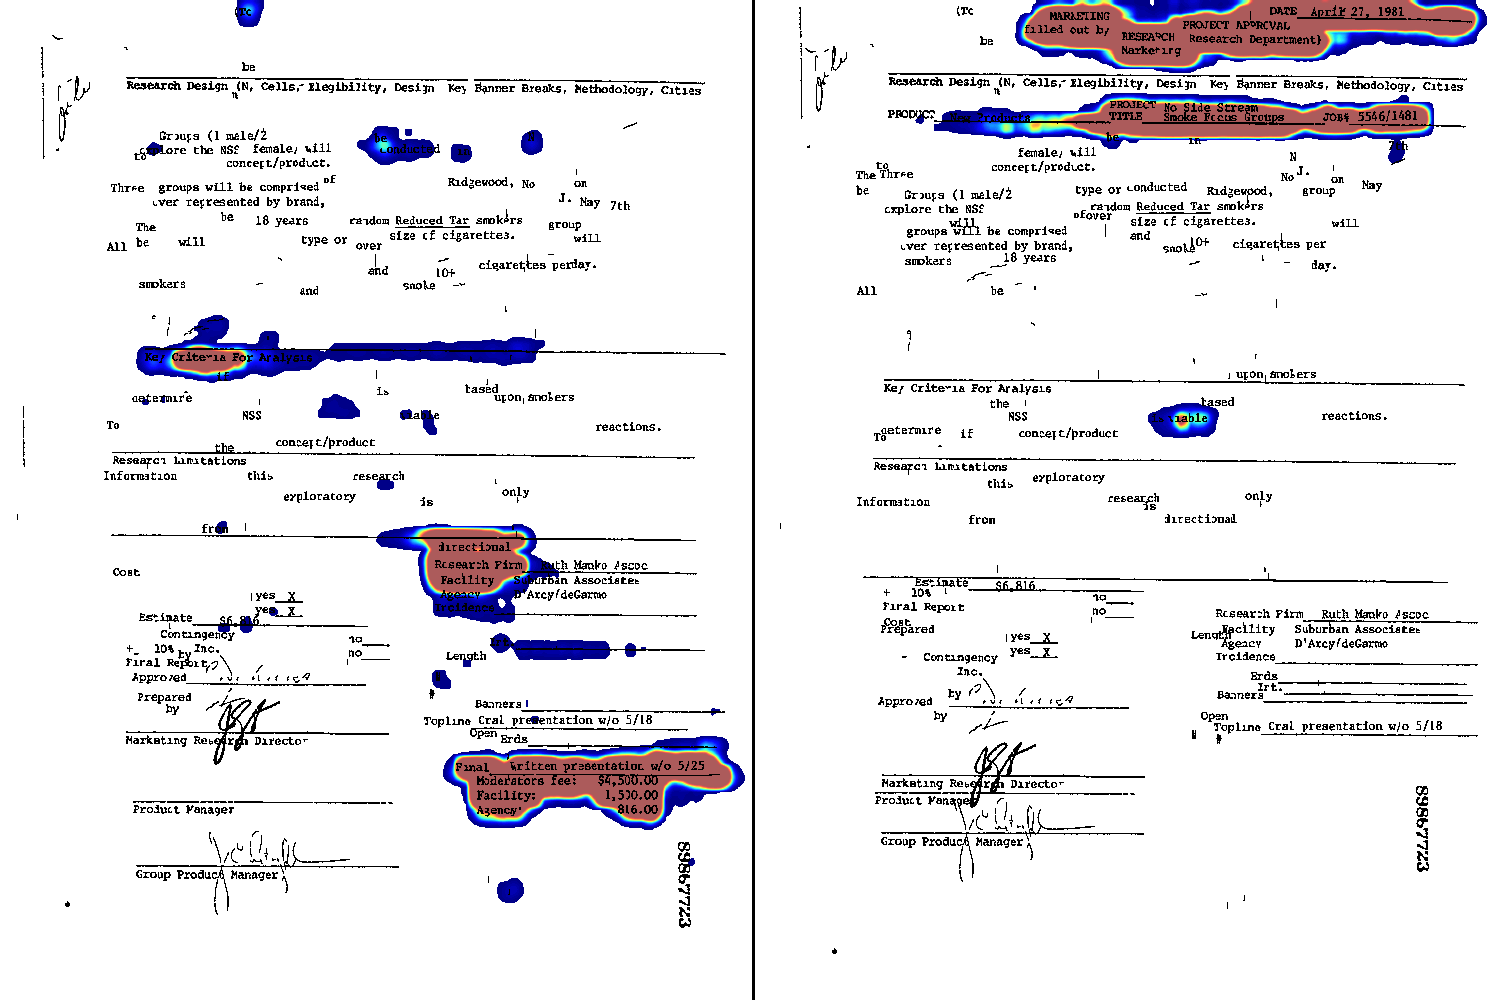

In [156]:
visualize_changes(left_img, right_img, pred_left_changes, pred_right_changes, blur_size=10)

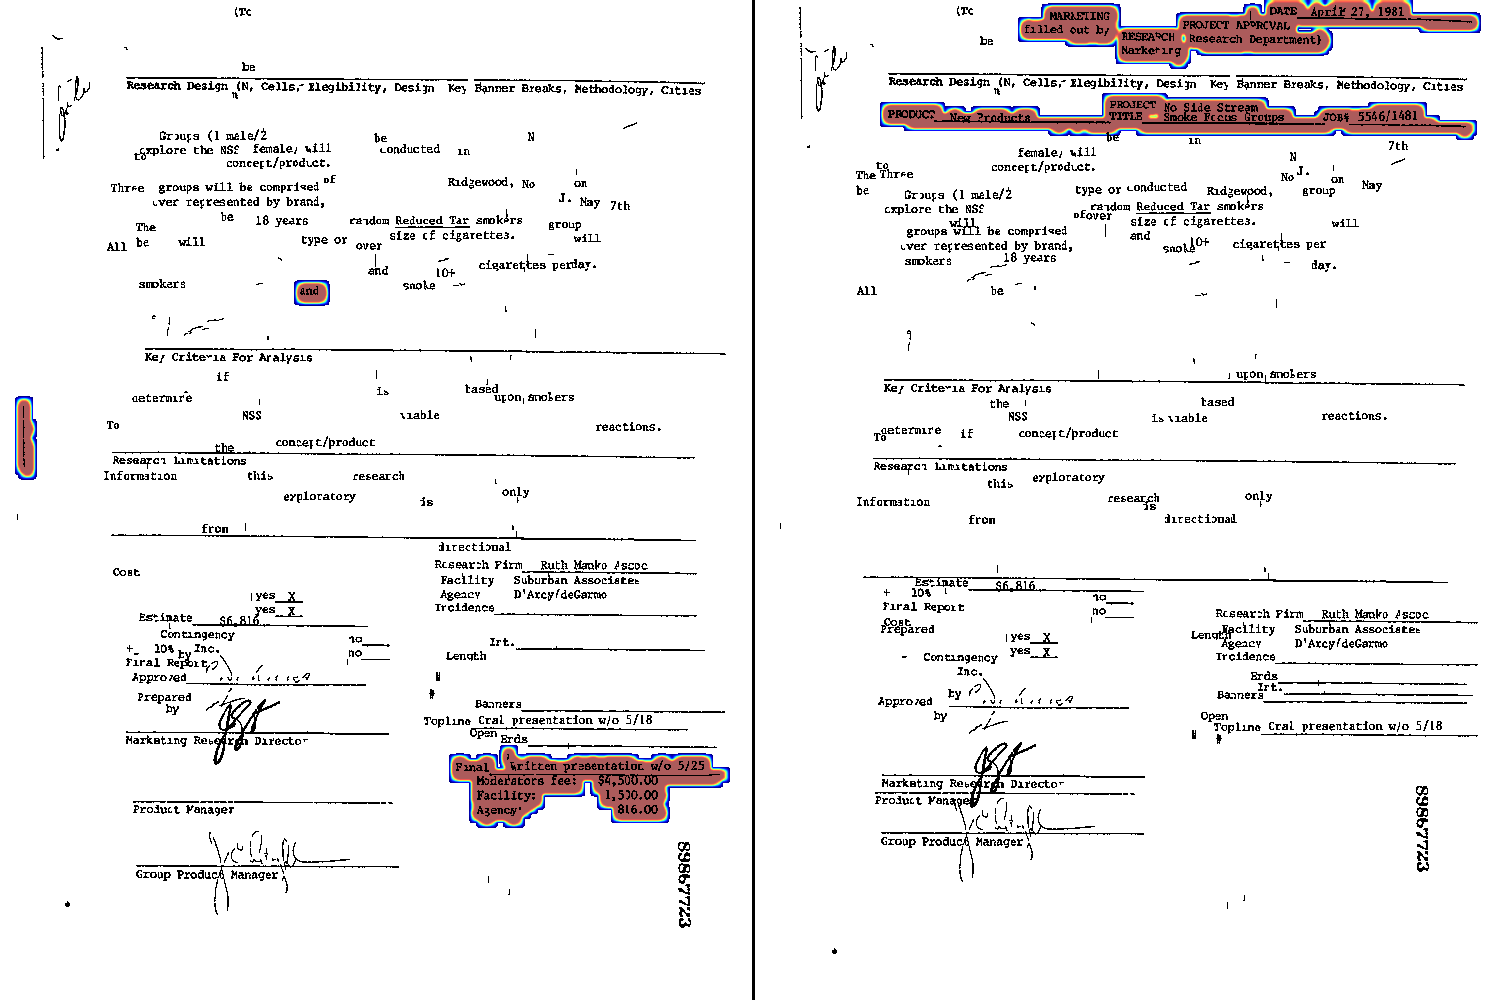

In [157]:
visualize_changes(left_img, right_img, left_changes, right_changes, blur_size=10)

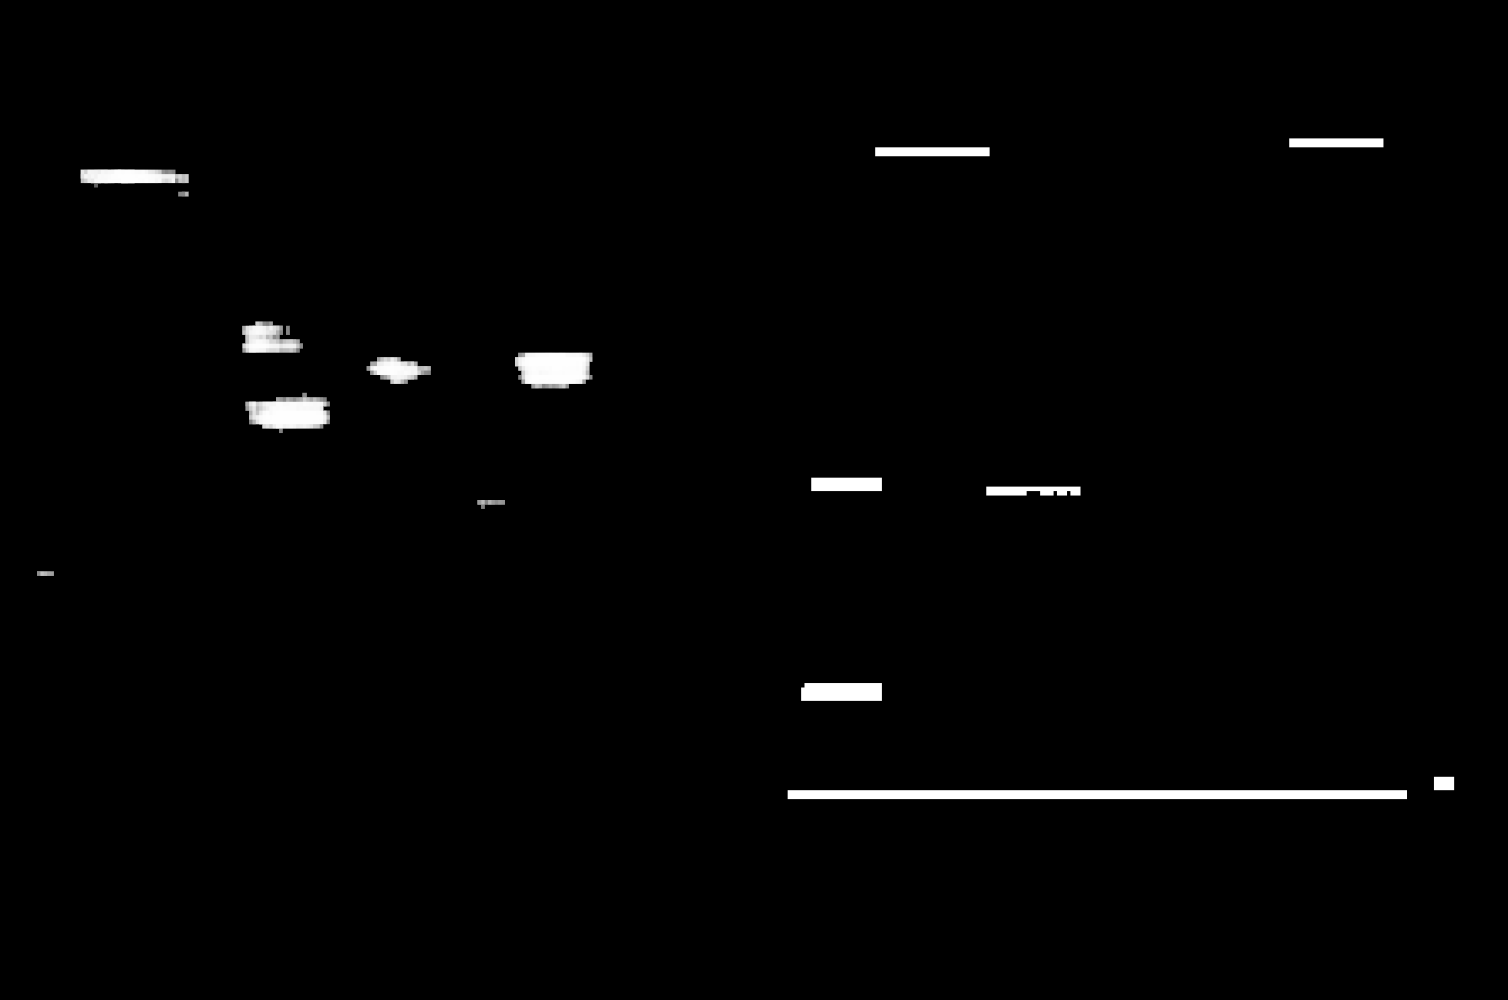

In [56]:
Image.fromarray(np.hstack((pred_left_changes, left_changes)))

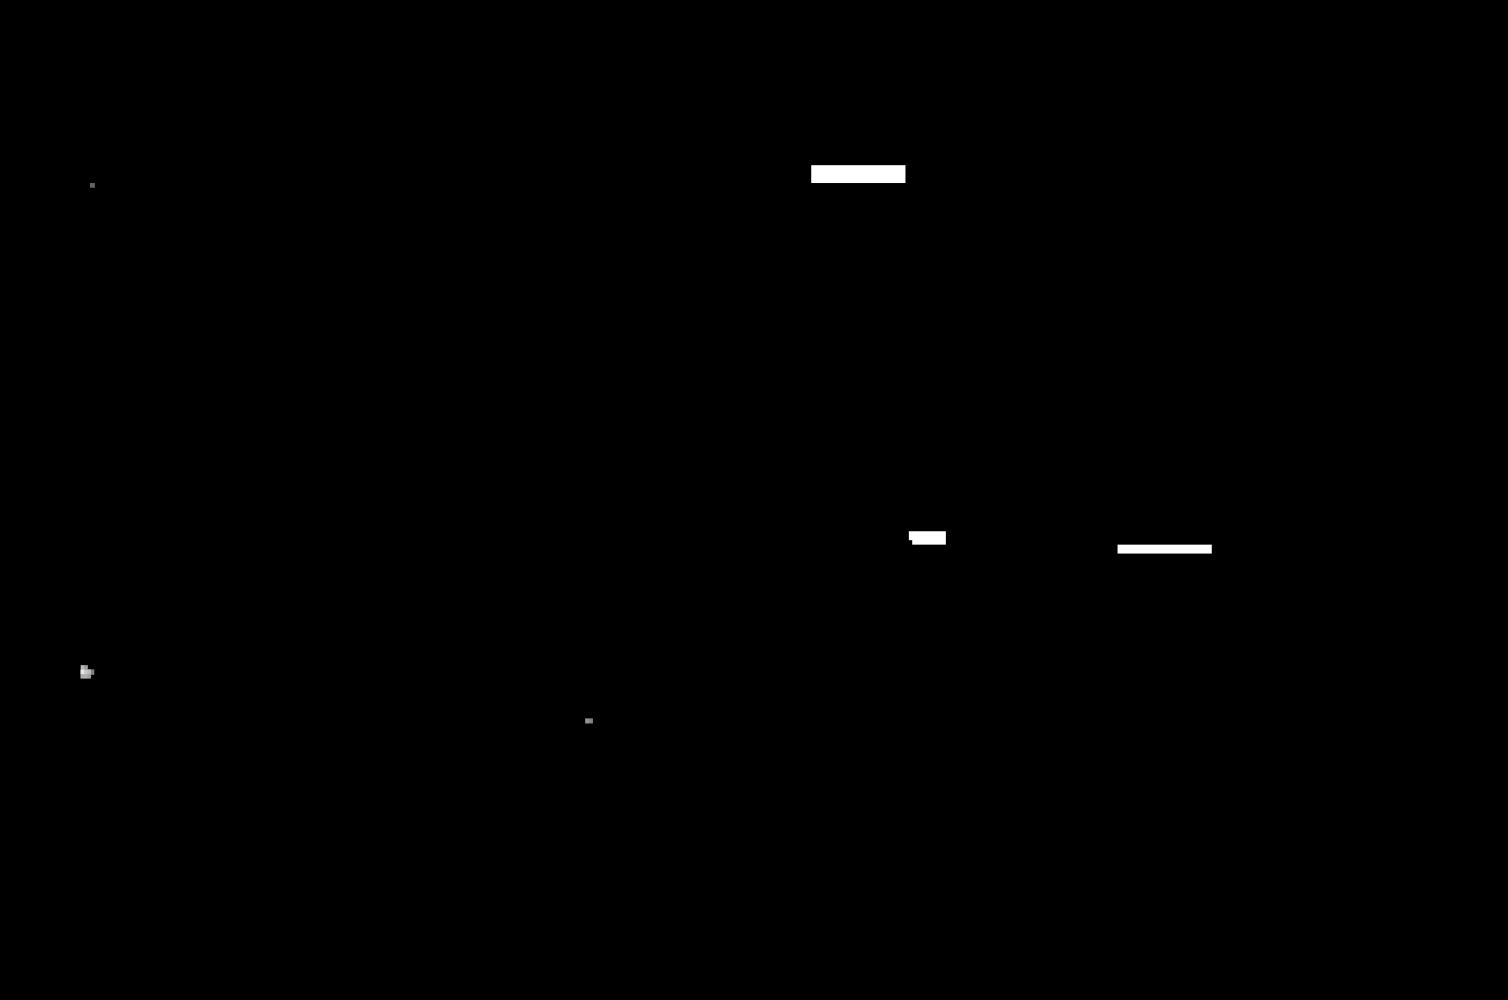

In [57]:
Image.fromarray(np.hstack((pred_right_changes, right_changes)))

In [ ]:
Image.fromarray(np.hstack((left_img, right_img))).save('left_right_ex.png')
Image.fromarray(np.hstack((pred_left_changes**2, left_changes))).save('left_changes_ex.png')
Image.fromarray(np.hstack((pred_right_changes**2, right_changes))).save('right_changes_ex.png')

# Try real Docs

In [229]:
model.load_state_dict(torch.load('docdiff.pth'))

<All keys matched successfully>

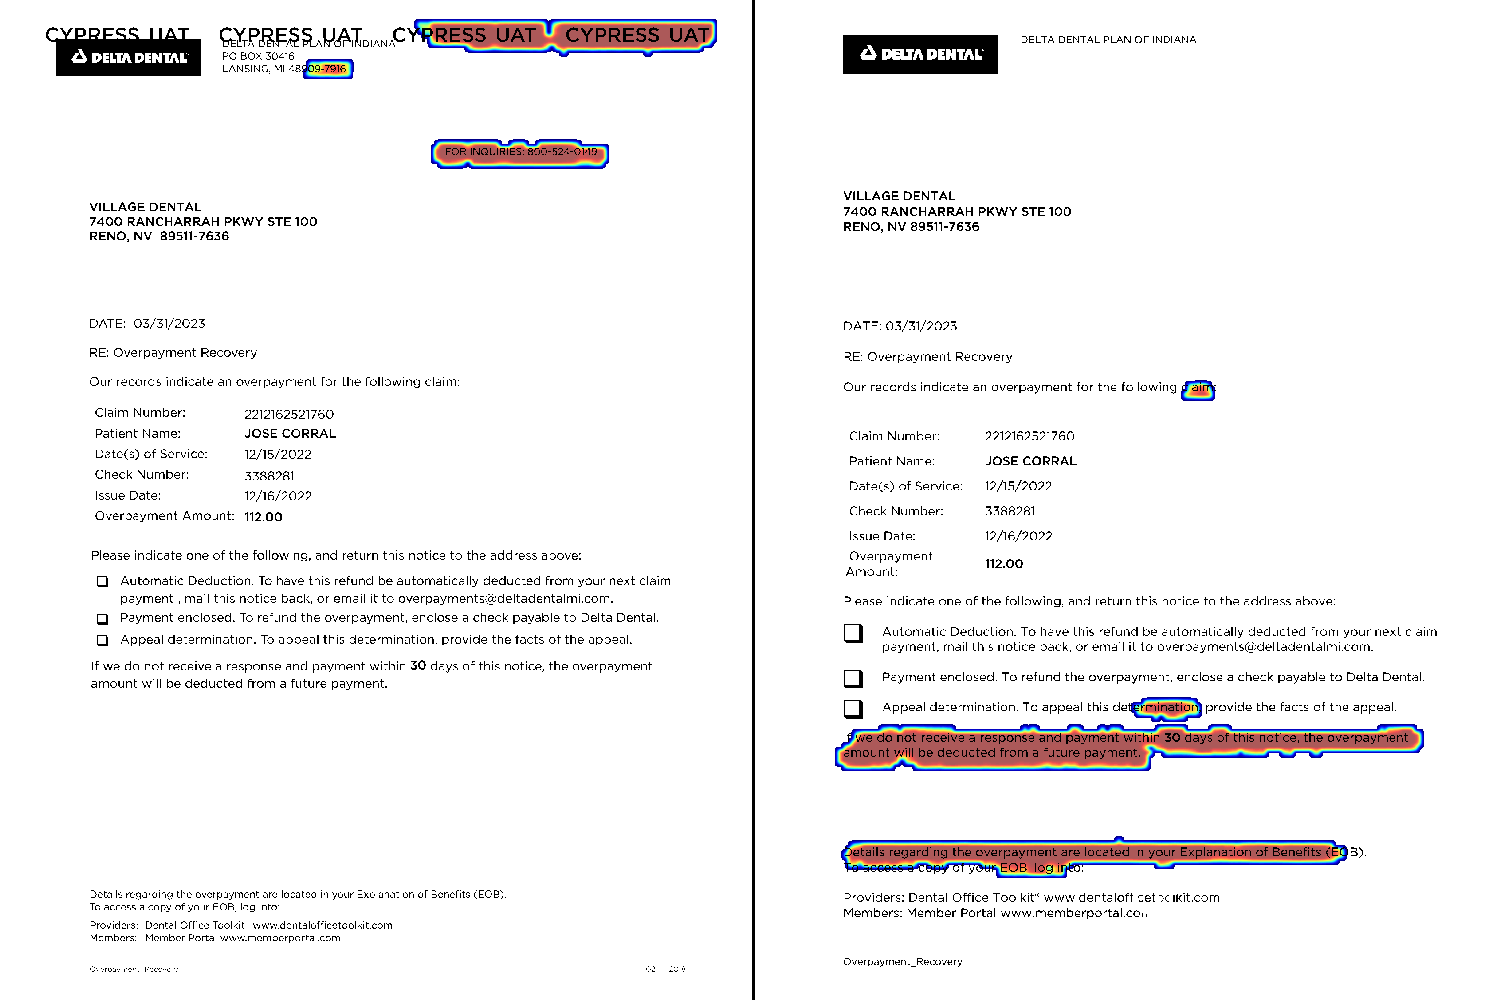

In [163]:
from pdf2image import convert_from_path

def filter_small_blobs(thresh, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
    new_thresh = thresh.copy()
    for i in range(1, num_labels):
        blob = labels == i
        if blob.sum() <= min_size:
            new_thresh[blob] = 0

    return new_thresh

def convert_to_binary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    return thresh

def get_image(path):
    img = np.array(convert_from_path(path, dpi=200, poppler_path="C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\poppler-0.68.0\\bin")[0])
    img = cv2.resize(img, (754, 1000), interpolation = cv2.INTER_NEAREST)
    thresh = convert_to_binary(img)
    
    # kernel = np.ones((1,2))
    # thresh = cv2.dilate(thresh, kernel, iterations=1)

    # thresh = filter_small_blobs(thresh, min_size=5)

    return thresh


# Claim Overpayment
# left = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\2107132377435_179096423_CLAIM_OVERPAYMENT_CY.pdf')
# right = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\2107132377435_179096423_CLAIM_OVERPAYMENT_Q.pdf')

# PROD_P
# left = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\2302232394007_PROD_P_596931528_CY.pdf')
# right = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\2302232394007_PROD_P_596931528_Q.pdf')

# DDS EOB
# left = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\2303295843136_DDS_PRED_598443148_CY.pdf')
# right = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\2303295843136_DDS_PRED_598443148_Q.pdf')

# Check Void
# left = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\199834444_3448471_CHECK_VOID_CY.pdf')
# right = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\199834444_3448471_CHECK_VOID_Q.pdf') # good

# checks base and target
# left = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\Checks_Base1.pdf')
# right = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\Checks_Target1.pdf')

# Overpayment
# left = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\2212162521760_197943258_OPAY_CY.pdf')
# right = get_image('C:\\Users\\bberg\\development\\PDF-comparison-algorithm\\test_docs\\2212162521760_197943258_OPAY_Q.pdf')

# left = cv2.resize(left, (754, 1000), interpolation = cv2.INTER_NEAREST)
# right = cv2.resize(right, (754, 1000), interpolation = cv2.INTER_NEAREST)

# left, left_gray = convert_to_binary(left)
# right, right_gray = convert_to_binary(right)

transform_img = transforms.Compose([transforms.Resize((224, 224), Image.NEAREST),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor(),
                                            ])

left_cuda = transform_img(Image.fromarray(left)).cuda().unsqueeze(0)
right_cuda = transform_img(Image.fromarray(right)).cuda().unsqueeze(0)

deal = nn.Sigmoid()
deal = nn.Softmax(dim=0)

with torch.no_grad():
    model = model.eval()
    output = model(left_cuda, right_cuda)
    output = deal(output[0][0]).cpu().numpy()
    
    out_class = output.argmax(axis=0)
    # bianry classification of left and right
    class_left = (cv2.resize((out_class==1).astype(float), (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(bool)
    class_right = (cv2.resize((out_class==0).astype(float), (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(bool)

    pred_left_changes = (cv2.resize(output[1,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
    pred_left_changes[~class_left] = 0

    pred_right_changes = (cv2.resize(output[0,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
    pred_right_changes[~class_right] = 0

    # pred_left_changes = (cv2.resize(output[1,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
    # pred_right_changes = (cv2.resize(output[0,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)

# label0 = label0.cpu().numpy().squeeze()
left_changes = (cv2.resize(label0[1,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)
right_changes = (cv2.resize(label0[0,:,:], (754, 1000), interpolation = cv2.INTER_AREA)*255).astype(np.uint8)

visualize_changes(left, right, pred_left_changes, pred_right_changes, blur_size=5)

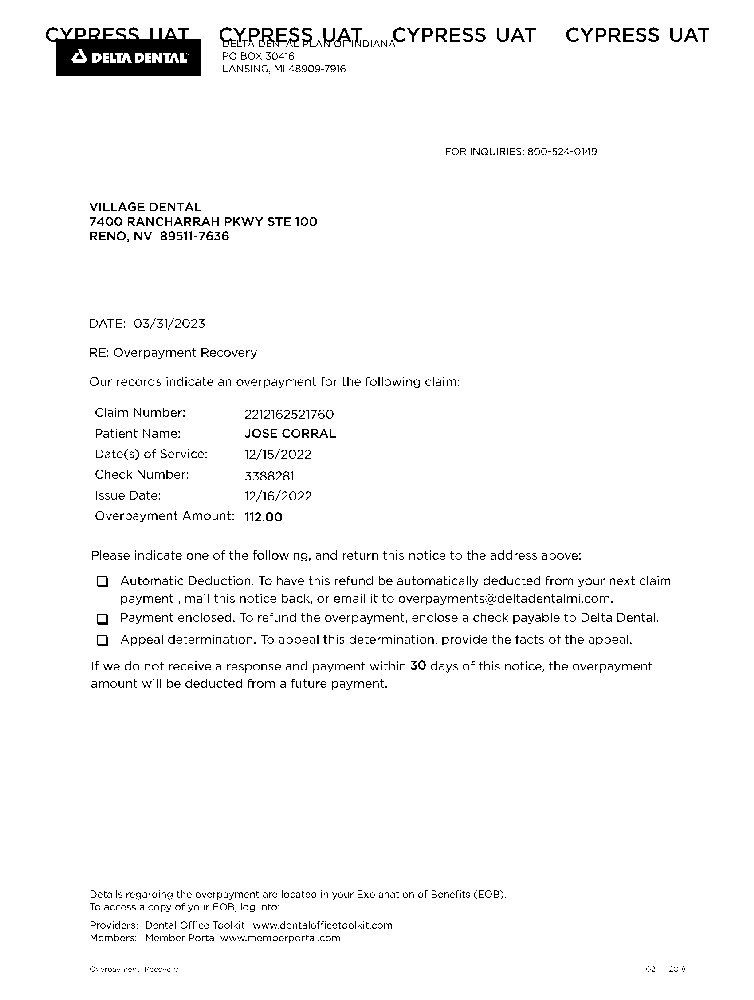

In [70]:
Image.fromarray(cv2.bitwise_not(left))

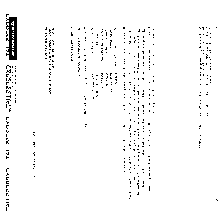

In [94]:
left_small = left_cuda.cpu().numpy().squeeze().transpose((2, 1, 0)).astype(float)*255
# left_small = cv2.bitwise_not(left_small*255)
left_small = cv2.bitwise_not(left_small.astype(np.uint8))